### Time Series Forecasting using XG Boost & LightGBM

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import clean data set
df = pd.read_csv("data/clean_dataset.csv")

In [3]:
df.head()

Unnamed: 0 business_unit client_typo  code_market code_resort loyal_new  \
0           0         CH-ML      Adults          370        AEXC       New   
1           1         CH-ML      Adults          370        AEXC       New   
2           2         CH-ML      Adults          370        ALBC     Loyal   
3           3         CH-ML      Adults          370        ALBC     Loyal   
4           4         CH-ML      Adults          370        ALBC     Loyal   

           market  month        resort                    sector_resort  \
0  CHINA MAINLAND     12  ARCS EXTREME                  EUROPE MOUNTAIN   
1  CHINA MAINLAND     12  ARCS EXTREME                  EUROPE MOUNTAIN   
2  CHINA MAINLAND      1        ALBION  EUROPE AFRICA SEA & COUNTRYSIDE   
3  CHINA MAINLAND      1        ALBION  EUROPE AFRICA SEA & COUNTRYSIDE   
4  CHINA MAINLAND      1        ALBION  EUROPE AFRICA SEA & COUNTRYSIDE   

     week_ref  year  nbr_gm  
0  2018-12-15  2018       2  
1  2019-12-14  2019       1  
2  2018-01-27  2018       9  
3  2019-01-26  2019       6  
4  2020-01-04  2020       2

In [4]:
df_copy = df.copy()

## Feature engineering
1. Perform date decomposition
2. Create categorical variables & OHE
3. Treat categorical variables
4. Train/Test Split
5. Create Lag Features
6. Rolling Mean
7. Fourier Transformation

In [5]:
# Drop month string column
df_copy.drop(columns = ['code_market', 'resort','year', 'month'], inplace = True)
df_copy.head()

Unnamed: 0 business_unit client_typo code_resort loyal_new          market  \
0           0         CH-ML      Adults        AEXC       New  CHINA MAINLAND   
1           1         CH-ML      Adults        AEXC       New  CHINA MAINLAND   
2           2         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   
3           3         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   
4           4         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   

                     sector_resort    week_ref  nbr_gm  
0                  EUROPE MOUNTAIN  2018-12-15       2  
1                  EUROPE MOUNTAIN  2019-12-14       1  
2  EUROPE AFRICA SEA & COUNTRYSIDE  2018-01-27       9  
3  EUROPE AFRICA SEA & COUNTRYSIDE  2019-01-26       6  
4  EUROPE AFRICA SEA & COUNTRYSIDE  2020-01-04       2

In [6]:
df_copy.head()

Unnamed: 0 business_unit client_typo code_resort loyal_new          market  \
0           0         CH-ML      Adults        AEXC       New  CHINA MAINLAND   
1           1         CH-ML      Adults        AEXC       New  CHINA MAINLAND   
2           2         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   
3           3         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   
4           4         CH-ML      Adults        ALBC     Loyal  CHINA MAINLAND   

                     sector_resort    week_ref  nbr_gm  
0                  EUROPE MOUNTAIN  2018-12-15       2  
1                  EUROPE MOUNTAIN  2019-12-14       1  
2  EUROPE AFRICA SEA & COUNTRYSIDE  2018-01-27       9  
3  EUROPE AFRICA SEA & COUNTRYSIDE  2019-01-26       6  
4  EUROPE AFRICA SEA & COUNTRYSIDE  2020-01-04       2

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200300 entries, 0 to 200299
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     200300 non-null  int64 
 1   business_unit  200300 non-null  object
 2   client_typo    200300 non-null  object
 3   code_resort    200300 non-null  object
 4   loyal_new      200300 non-null  object
 5   market         200300 non-null  object
 6   sector_resort  200300 non-null  object
 7   week_ref       200300 non-null  object
 8   nbr_gm         200300 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 13.8+ MB


In [8]:
# Sort dates
df_copy.sort_values(by = ['week_ref'], axis = 0, inplace = True)

### 1. Perform Date Decomposition
 * This will be used for features for future models

In [9]:

def weekref_breakdown(df):
    df['week_ref']= pd.to_datetime(df["week_ref"])
    df['year'] = df['week_ref'].dt.year
    df['month'] = df['week_ref'].dt.month
    df['week'] = df['week_ref'].dt.isocalendar().week
    return df

In [10]:
weekref_breakdown(df_copy)

Unnamed: 0  business_unit client_typo code_resort loyal_new  \
97324       112011            EAF      Family        PCAC     Loyal   
192597      216826  SOUTH AMERICA      Adults        RDPC       New   
135578      154459           ESAP      Adults        KANC       New   
92579       106381            EAF      Family        GMAC       New   
135453      154334           ESAP      Adults        KANC     Loyal   
...            ...            ...         ...         ...       ...   
174604      196754  NORTH AMERICA      Adults        TIGC     Loyal   
104181      120027            EAF      Family        MPAC       New   
169421      190931  NORTH AMERICA      Adults        TURC     Loyal   
198038      222882  SOUTH AMERICA      Family        CANC     Loyal   
188912      212766  SOUTH AMERICA      Adults        PRAC       New   

                  market                    sector_resort   week_ref  nbr_gm  \
97324              ITALY                    NORTH AMERICA 2017-12-30       4   
192597         ARGENTINA                    SOUTH AMERICA 2017-12-30      10   
135578  HONG KONG MARKET                         ASIA SUN 2017-12-30       1   
92579        SWITZERLAND                  EUROPE MOUNTAIN 2017-12-30       2   
135453  HONG KONG MARKET                         ASIA SUN 2017-12-30       2   
...                  ...                              ...        ...     ...   
174604            CANADA                  EUROPE MOUNTAIN 2023-12-30       1   
104181    UNITED KINGDOM  EUROPE AFRICA SEA & COUNTRYSIDE 2023-12-30       9   
169421               USA                    NORTH AMERICA 2023-12-30      21   
198038         ARGENTINA                    NORTH AMERICA 2023-12-30       3   
188912            BRAZIL                  EUROPE MOUNTAIN 2023-12-30       1   

        year  month  week  
97324   2017     12    52  
192597  2017     12    52  
135578  2017     12    52  
92579   2017     12    52  
135453  2017     12    52  
...      ...    ...   ...  
174604  2023     12    52  
104181  2023     12    52  
169421  2023     12    52  
198038  2023     12    52  
188912  2023     12    52  

[200300 rows x 12 columns]

### Aggreggate data by week

In [11]:
## Group data by date
df_agg = df_copy.groupby(["week_ref","year","month","week"])["nbr_gm"].sum().reset_index()

In [12]:
df_agg.tail()

week_ref  year  month  week  nbr_gm
309 2023-12-02  2023     12    48   17695
310 2023-12-09  2023     12    49   20368
311 2023-12-16  2023     12    50   31081
312 2023-12-23  2023     12    51   38501
313 2023-12-30  2023     12    52   18497

### 2. Fuctions for Transposing rows, lags, rolling means and fourier transformation

In [13]:
def process_data(df, condition = ['week_ref']):

    """
    Aggreggates data by week and creates a feature for each variable in the aggreggation. The value is the sume of the variable count for each week. Meant to serve as additional features for modeling
    """
    
    summed_nbr_gm = df.groupby(condition)['nbr_gm'].sum().reset_index()

    categories = df.drop(columns=condition + ['nbr_gm'])


    dummies = pd.get_dummies(categories, dtype=int)


    dummies[condition] = df[condition]

    summed_dummies = dummies.groupby(condition).sum().reset_index()

    processed_data = pd.merge(summed_nbr_gm, summed_dummies, on=condition, how='outer')
    
    processed_data.drop(["Unnamed: 0"], axis=1, inplace=True)

    processed_data['week_ref']= pd.to_datetime(processed_data["week_ref"])
    processed_data['year'] = processed_data['week_ref'].dt.year
    processed_data['month'] = processed_data['week_ref'].dt.month
    processed_data['week'] = processed_data['week_ref'].dt.isocalendar().week

    return processed_data


### Lag Features

In [14]:
# Creating lag features for time-series data

def create_lag_features(data, lag_steps=1):
    dataframe = data.copy()
    for i in range(1, lag_steps + 1):

        dataframe[f'week_lag_{i}'] = dataframe['nbr_gm'].shift(i)

    return dataframe

### Rolling Mean 

- Captures trendsd over short periods

In [15]:
# Creating rolling mean for time-series data

def create_rolling_mean(df, window_size=3):

    df['rolling_mean'] = df['nbr_gm'].rolling(window=window_size).mean()

    return df

### Add Fourier Transformation for capturing seasonality

In [16]:
from scipy.fft import fft

def apply_fourier_transform(df):

    values = df['nbr_gm'].values

    fourier_transform = fft(values)

    df['fourier_transform'] = np.abs(fourier_transform)

    return df

### Function with lag, rolling mean an fourier

In [17]:
## Create a global function

def time_series_var(data,lag_calc = True, lag_steps = 2, rolling_mean = True, window_size = 9, fourier = True): # Lag and Rolling mean pulled from PACF and ACF respectively
    """
    Function to take a dataset through feature engineering for lag, rolling mean and fourier transformation
    """

    from scipy.fft import fft
    
    dataframe = data.copy()
    if lag_calc == True:
        for i in range(1, lag_steps + 1):

            dataframe[f'week_lag_{i}'] = dataframe['nbr_gm'].shift(i)

    if rolling_mean == True:
        dataframe['rolling_mean'] = dataframe['nbr_gm'].rolling(window=window_size).mean()

    if fourier:
        # Handling NaNs by filling with an appropriate value or interpolation before FFT
        values = dataframe['nbr_gm'].fillna(method='ffill').values  # Example: forward fill
        
        if len(values) > 0:
            fourier_transform = fft(values)
            dataframe['fourier_transform'] = np.abs(fourier_transform)
        else:
            dataframe['fourier_transform'] = np.nan

    
    return dataframe

### 4. Split train/test sets before feature engineering

In [18]:
# Split into train and test set prior to feature engineering
split_time = '2023-01-01'

def split_data(df, split_time):
    """
    Splits data set into train and test sets based off split_time
    """
    # Set up train and test set
    train = df[df["week_ref"] < split_time]
    test = df[df["week_ref"] >= split_time]
    return train, test

### 5. Transform data set & Model
We will create 3 data frames using the functions above:
1. Date time breakdown. Just use date data. We will call this `date_df`
2. `date_df` + lag, rolling mean and fourier transformation. We will call it `time_series_feautures_df`
3. `time_series_feautures_df` 2 + `process` function. We will call it `process_df`

We will then take these dataframes and model using XGBoost to compare the errors. We will predict the overall nbr_gm (number of guests) as this is the most complete dataset and will most likely yield the lowest error. 

#### date_df predictions

In [19]:
# Create a date df
date_df = df_agg.copy()

# Split the data
split_time = '2023-01-01' # This will be used for every dataframe going forward
train,test = split_data(date_df, split_time)

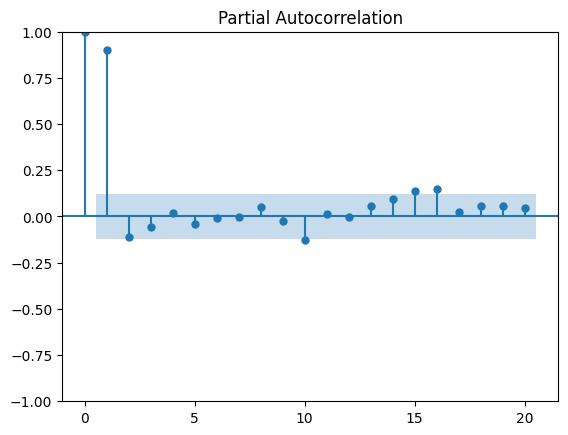

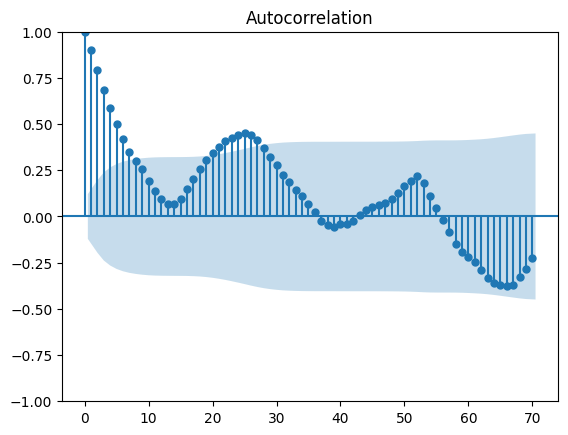

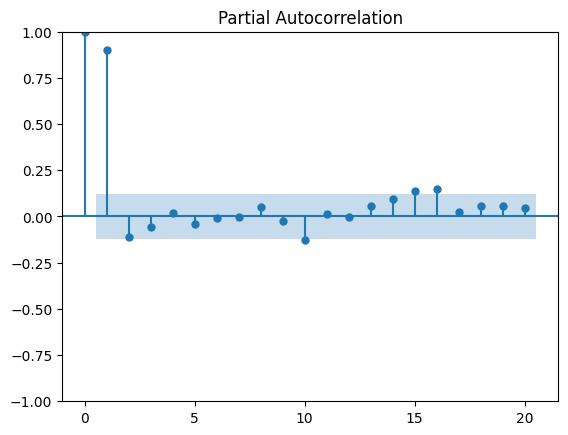

In [20]:
# Check autocorrelation and partial autocorrelation to use in time series variables
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(train["nbr_gm"], lags = 70)

# plot PACF
plot_pacf(train["nbr_gm"], lags = 20)

There is a strong partial autocorrelation of up to 2 lags. That is already incorporated into the lag function default.

ACF leads us to believe a rolling mean of around 9 will be beneficial to account for dependancies in the previous 8 days. That is accounted for in the rolling mean funciton above.

In [21]:
# Update each row with time series variables 
train_updated = train # just updating the variable to be used in the split below
test_updated = test # just updating the variable to be used in the split below

In [22]:
# Split intro train and split
X_train = train_updated.drop(columns = 'nbr_gm')
X_test = test_updated.drop(columns = 'nbr_gm')

# Drop "week_ref" column
X_train = X_train.drop(columns = "week_ref")
X_test = X_test.drop(columns = "week_ref")

y_train = train["nbr_gm"]
y_test = test["nbr_gm"]

In [23]:
# Create a function to calculate sMAPE
def sMAPE(yact, ypred):
    denominator = (np.abs(yact) + np.abs(ypred)) / 2.0
    diff = np.abs(yact - ypred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [24]:
import xgboost as xgb

# Instantiate model
reg = xgb.XGBRegressor()

# Fit model
reg.fit(X_train, y_train)

# Predictions
y_preds = reg.predict(X_test)

# Error

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test,y_preds)
mape = mean_absolute_percentage_error(y_test,y_preds)
smape = sMAPE(y_test,y_preds)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"sMAPE: {smape}")

RMSE: 6251.17776065338
MAE: 4618.1120042067305
MAPE: 0.1939831101743229
sMAPE: 0.2225155316408993


SMAPE will serve as our benchmark to compare all of the errors for each dataframe

### time_series_df

In [25]:
time_series_df = df_agg.copy()

# Create a train and test split to apply transforms to
train,test = split_data(time_series_df, split_time)

In [26]:
# Update each row with time series variables 
train_updated = time_series_var(train)
test_updated = time_series_var(test)

In [27]:
# Split intro train and split
X_train = train_updated.drop(columns = 'nbr_gm')
X_test = test_updated.drop(columns = 'nbr_gm')

# Drop "week_ref" column
X_train = X_train.drop(columns = "week_ref")
X_test = X_test.drop(columns = "week_ref")

y_train = train["nbr_gm"]
y_test = test["nbr_gm"]

In [28]:
import xgboost as xgb

# Instantiate model
reg = xgb.XGBRegressor()

# Fit model
reg.fit(X_train, y_train)

# Predictions
y_preds = reg.predict(X_test)

# Error

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test,y_preds)
mape = mean_absolute_percentage_error(y_test,y_preds)
smape = sMAPE(y_test,y_preds)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"sMAPE: {smape}")

RMSE: 4948.525462946519
MAE: 3652.131366436298
MAPE: 0.16746952469057874
sMAPE: 0.16887755041552174


Error improved by little bit less than 6% overall 

### Process_df

In [29]:
# Creater a process df
process_df = process_data(df_copy)

# Split the data
train,test = split_data(process_df, split_time)

# Update each row with time series variables 
train_updated = time_series_var(train)
test_updated = time_series_var(test)

In [30]:
# Split intro train and split
X_train = train_updated.drop(columns = 'nbr_gm')
X_test = test_updated.drop(columns = 'nbr_gm')

# Drop "week_ref" column
X_train = X_train.drop(columns = "week_ref")
X_test = X_test.drop(columns = "week_ref")

y_train = train["nbr_gm"]
y_test = test["nbr_gm"]

In [31]:
X_test.head()

year  month  week  business_unit_CH-ML  business_unit_EAF  \
262  2023      1     1                   44                504   
263  2023      1     2                   53                493   
264  2023      1     3                   53                563   
265  2023      1     4                   42                591   
266  2023      2     5                   41                591   

     business_unit_ESAP  business_unit_NORTH AMERICA  \
262                 231                          126   
263                 232                          129   
264                 285                          146   
265                 185                          138   
266                 193                          135   

     business_unit_SOUTH AMERICA  client_typo_Adults  client_typo_Family  ...  \
262                          121                 583                 443  ...   
263                          124                 598                 433  ...   
264                          132                 667                 512  ...   
265                          114                 632                 438  ...   
266                          108                 630                 438  ...   

     sector_resort_EUROPE AFRICA SEA & COUNTRYSIDE  \
262                                             94   
263                                            102   
264                                             91   
265                                             92   
266                                             86   

     sector_resort_EUROPE MOUNTAIN  sector_resort_JOYVIEW  \
262                            441                     15   
263                            406                     15   
264                            519                     16   
265                            490                     16   
266                            479                     13   

     sector_resort_NORTH AMERICA  sector_resort_SOUTH AMERICA  \
262                          165                           36   
263                          178                           35   
264                          183                           32   
265                          173                           32   
266                          174                           41   

     sector_resort_URBAN OASIS  week_lag_1  week_lag_2  rolling_mean  \
262                          0         NaN         NaN           NaN   
263                          0     26311.0         NaN           NaN   
264                          0     26791.0     26311.0           NaN   
265                          0     32431.0     26791.0           NaN   
266                          0     26362.0     32431.0           NaN   

     fourier_transform  
262       1.187942e+06  
263       4.774572e+04  
264       1.747937e+05  
265       6.978008e+04  
266       5.770407e+04  

[5 rows x 145 columns]

In [32]:
X_train.shape, y_train.shape

((262, 145), (262,))

In [33]:
X_test.shape, y_test.shape

((52, 145), (52,))

In [34]:
import xgboost as xgb

# Instantiate model
reg = xgb.XGBRegressor()

# Fit model
reg.fit(X_train, y_train)

# Predictions
y_preds = reg.predict(X_test)

# Error

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test,y_preds)
mape = mean_absolute_percentage_error(y_test,y_preds)
smape = sMAPE(y_test,y_preds)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"sMAPE: {smape}")



RMSE: 3039.1930271530346
MAE: 2241.964374248798
MAPE: 0.09681948227151314
sMAPE: 0.10105781897155454


Error improved by 12% from the basic dataframe with no feature engineering done

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

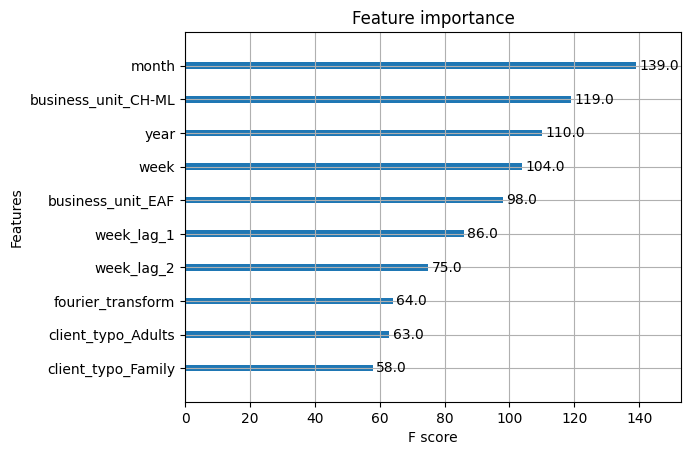

In [35]:
# Check top features
xgb.plot_importance(reg, max_num_features = 10)

In [36]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})
comparison_df[:10]

Actual     Predicted
262   26311  25205.087891
263   26791  21989.044922
264   32431  27485.929688
265   26362  28179.226562
266   26592  25362.355469
267   29412  30668.705078
268   29421  30408.125000
269   27322  27648.904297
270   25701  27594.685547
271   26101  20628.035156

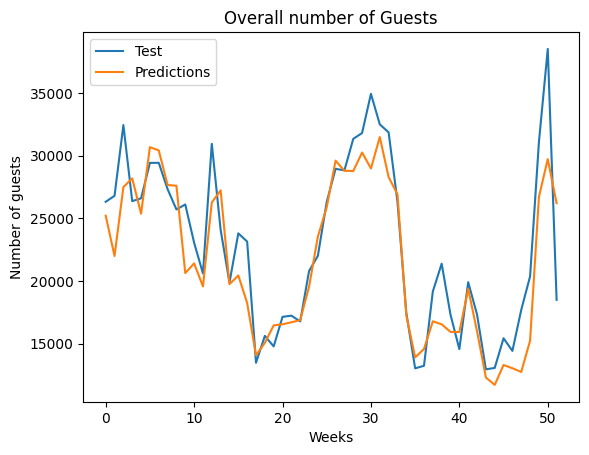

In [37]:
# Plot time series
# plt.plot(X_train.index, y_train, label = "Train")
plt.plot(comparison_df["Actual"].values, label = "Test")
plt.plot(comparison_df["Predicted"].values, label = "Predictions")

plt.xlabel("Weeks")
plt.ylabel("Number of guests")
plt.title("Overall number of Guests")
plt.legend()

In [38]:
## Check a dictionairy of models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


models = {#"Linear" : LinearRegression(),
    #"DT": DecisionTreeRegressor(),
    #"RF": RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'Light GBM' : lgb.LGBMRegressor()
            }

def check_ml_scores(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, models = models):
    """
    Run through models to find best scores
    """
    #Instantiate a list for each model's results
    
    results = []
    for name, model in models.items():

        reg = model 

        # Fit model
        reg.fit(X_train, y_train);

        # Predictions
        y_preds = reg.predict(X_test);

        # Error

        from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        mae = mean_absolute_error(y_test,y_preds)
        mape = mean_absolute_percentage_error(y_test,y_preds)
        smape = sMAPE(y_test,y_preds)

        results.append({"Model": name, "RMSE": rmse, "MAE": mae, "MAPE":mape, "SMAPE":smape})
    
    results_df = pd.DataFrame(results)

    return results_df


In [39]:
check_ml_scores()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3858
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 135
[LightGBM] [Info] Start training from score 14474.793893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Model         RMSE          MAE      MAPE     SMAPE
0    XGBoost  3039.193027  2241.964374  0.096819  0.101058
1  Light GBM  2786.758205  2007.438967  0.086204  0.087591

## Hyperparam Tuning

### XGBoost

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'eta':[0.01, 0.05, 0.2, 0.3],
            'n_estimators': [100,200,500,1000],
            'max_depth': [2,4,6,8,12]}

random_search = GridSearchCV(estimator = xgb.XGBRegressor(),
                                    param_grid = params,
                                    # n_iter = 12, # For RandomSearch
                                    n_jobs = -1,
                                    cv = 5)

new_reg = random_search.fit(X_train, y_train)



In [41]:
new_reg.best_params_

{'eta': 0.05, 'max_depth': 2, 'n_estimators': 1000}

In [42]:
# Use best model to predict nbr_gm
y_preds_hyper = new_reg.best_estimator_.predict(X_test)

# Check score
smape = sMAPE(y_test,y_preds_hyper)
smape

0.08366351037932195

In [43]:
comparison_df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds_hyper})
comparison_df2[:10]

Actual     Predicted
262   26311  22428.619141
263   26791  25294.330078
264   32431  26734.314453
265   26362  25210.953125
266   26592  25153.832031
267   29412  30567.402344
268   29421  29659.730469
269   27322  29838.494141
270   25701  26695.496094
271   26101  22597.742188

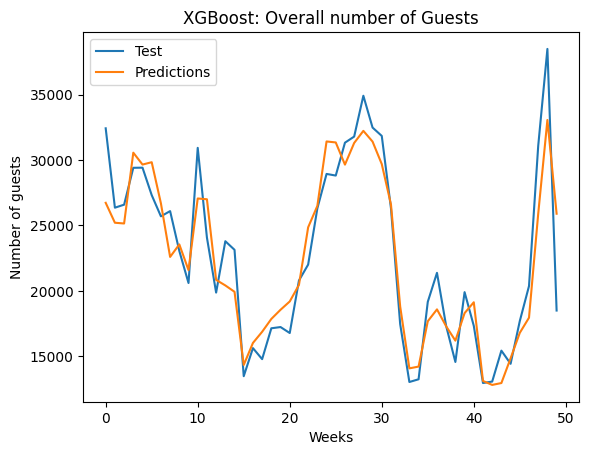

In [44]:
# Plot time series
# plt.plot(X_train.index, y_train, label = "Train")
plt.plot(comparison_df2["Actual"][2:].values, label = "Test")
plt.plot(comparison_df2["Predicted"][2:].values, label = "Predictions")

plt.xlabel("Weeks")
plt.ylabel("Number of guests")
plt.title("XGBoost: Overall number of Guests")
plt.legend()

### LightGBM

In [45]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

params = {
    'learning_rate': [0.01, 0.05, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
    'num_leaves': [7, 15, 31, 63],  
}

grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(),
                           param_grid=params,
                           n_jobs=-1,
                           cv=5)  # You might want to specify the number of folds for cross-validation

# Assuming X_train and y_train are defined
new_reg = grid_search.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3858
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 135
[LightGBM] [Info] Start training from score 14474.793893


In [46]:
new_reg.best_params_

{'learning_rate': 0.2, 'n_estimators': 1000, 'num_leaves': 7}

In [47]:
# Use best model to predict nbr_gm
y_preds_hyper = new_reg.best_estimator_.predict(X_test)

# Check score
smape = sMAPE(y_test,y_preds_hyper)
smape

0.09104466885799992

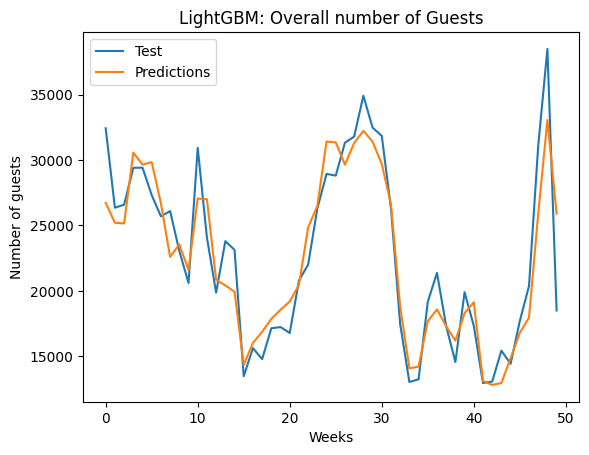

In [48]:
# Plot time series
# plt.plot(X_train.index, y_train, label = "Train")
plt.plot(comparison_df2["Actual"][2:].values, label = "Test")
plt.plot(comparison_df2["Predicted"][2:].values, label = "Predictions")

plt.xlabel("Weeks")
plt.ylabel("Number of guests")
plt.title("LightGBM: Overall number of Guests")
plt.legend()

A "respectful" MAPE value largely depends on the context of the analysis, the industry standards, and the complexity of the data being forecasted. Generally, MAPE is used to assess the accuracy of forecasting models by comparing predicted values to actual values in percentage terms. The acceptability of a MAPE value is subjective and varies by application area. Here's a general guide to interpreting MAPE values:

MAPE < 10%: Excellent. The model's forecasts are very close to the actual values.
MAPE between 10% and 20%: Good. The forecasts are reasonable and can be considered accurate for many applications.
MAPE between 20% and 50%: Fair. The accuracy is moderate, and the model might need improvement, depending on the application.
MAPE > 50%: Poor. The model's forecasts are inaccurate and likely need significant revisions or reconsideration of the forecasting approach.

## Business Unit Predictions

Business Unit = Geographical group of client origin

In [49]:
# Plot errors and output over business units

split_time = '2023-01-01'
def plot_feature_categories(df, feature, model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 200), split_time = split_time):
    """
    1. Groups data by feature and aggregates
    2. Splits into train and test
    3. Adds time series variables
    4. Trains model and makes predictions
    5. Calculates errors
    6. Plots predictions vs. test results
    """
    results_feature = []
    for feature_unit in sorted(df[feature].unique()): #prints alphabetically
        df_feature = df[df[feature] == feature_unit]
        df_agg = df_feature.groupby(["week_ref","year","month","week"]).agg({'nbr_gm' : "sum"}).reset_index()

        # Train Test Split
        train,test = split_data(df_agg, split_time)

        # Add time series variables
        train_updated = time_series_var(train)
        test_updated = time_series_var(test)

        # Set up X_train, X_test, y_train, y_test
        # Split intro train and split
        X_train = train_updated.drop(columns = 'nbr_gm')
        X_test = test_updated.drop(columns = 'nbr_gm')

        # Drop "week_ref" column
        X_train = X_train.drop(columns = "week_ref")
        X_test = X_test.drop(columns = "week_ref")

        y_train = train["nbr_gm"]
        y_test = test["nbr_gm"]

        # Instantiate model
        reg = model

        # Fit model
        reg.fit(X_train, y_train);

        # Predictions
        y_preds = reg.predict(X_test);

        # Error

        from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        mae = mean_absolute_error(y_test,y_preds)
        mape = mean_absolute_percentage_error(y_test,y_preds)
        smape = sMAPE(y_test,y_preds)

        results_feature.append({f"{feature}": feature_unit, "RMSE": rmse, "MAE": mae, "MAPE":mape, "SMAPE":smape, "Total rows": len(y_test)})
        # "Total rows" was used to check if we had data for each week as a possible reason for higher error
    

        # Plot
        comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds}) # Create a dataframe to plot the y_text vs. y_preds

        plt.figure(figsize = (10,5))
        plt.plot(comparison_df["Actual"].values, label = "Test")
        plt.plot(comparison_df["Predicted"].values, label = "Predictions")

        plt.xlabel("Weeks")
        plt.ylabel("Number of guests")
        plt.title(f"Overall number of {feature_unit} Guests")
        plt.legend()

    results_df = pd.DataFrame(results_feature)
    
    return results_df.sort_values(by="MAPE")

business_unit         RMSE          MAE      MAPE     SMAPE  Total rows
1            EAF  1822.676103  1360.324407  0.156940  0.159368          52
2           ESAP  1058.152587   738.669368  0.177125  0.181209          52
3  NORTH AMERICA   965.449500   762.494655  0.253392  0.246818          52
4  SOUTH AMERICA  1058.771547   570.548632  0.301232  0.265073          52
0          CH-ML  1721.288787  1259.860018  0.369974  0.340705          52

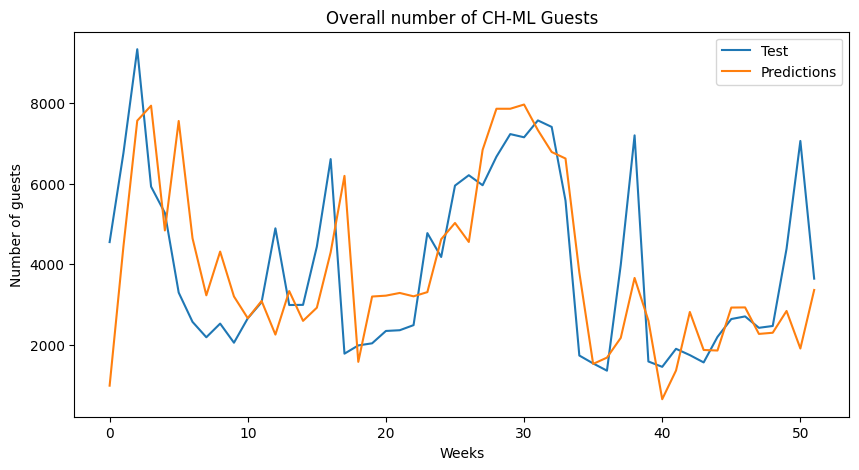

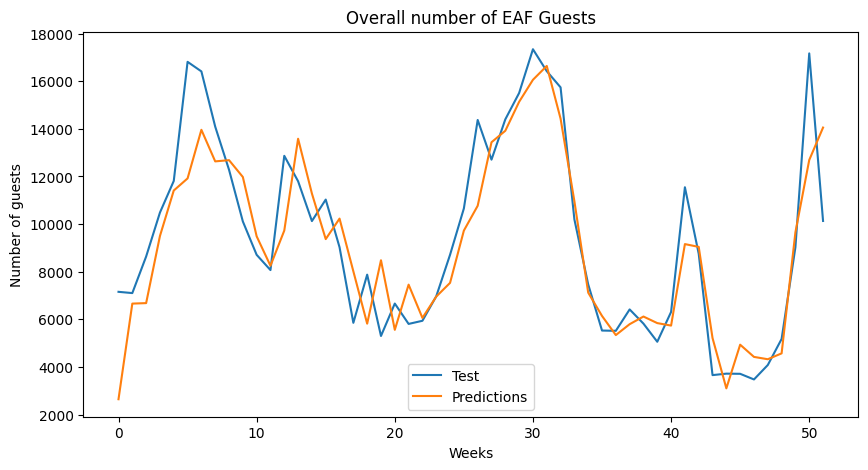

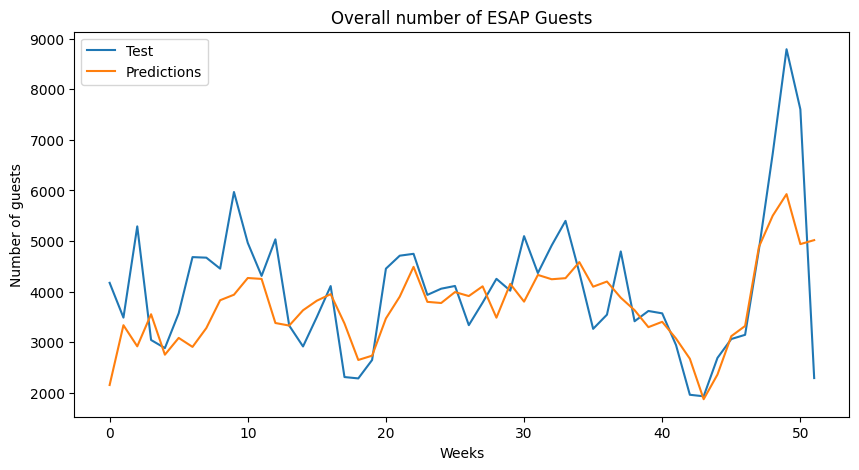

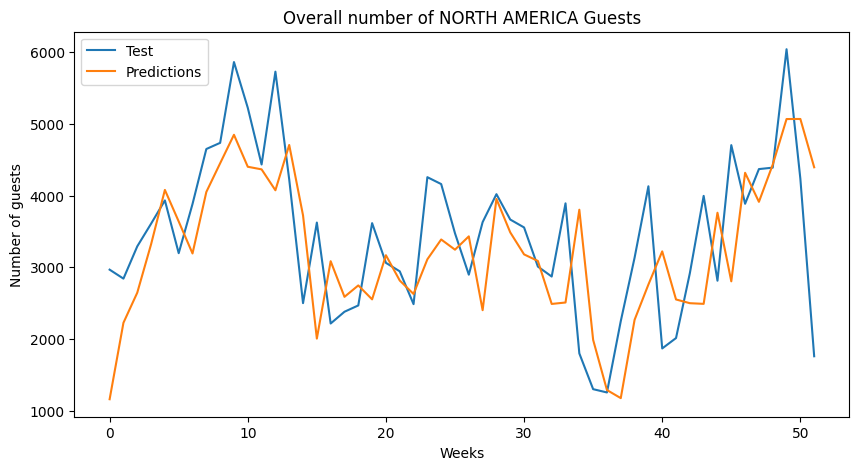

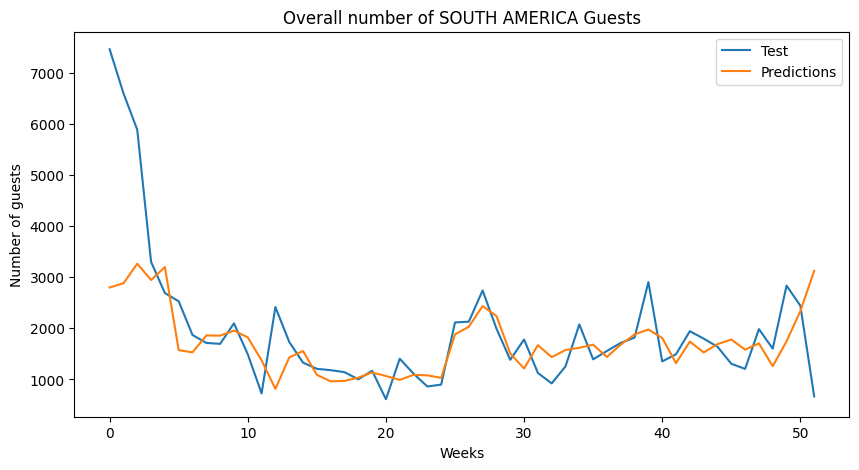

In [50]:
plot_feature_categories(df = df_copy, feature = 'business_unit')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 261, number of used features: 7
[LightGBM] [Info] Start training from score 2364.425287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

business_unit         RMSE          MAE      MAPE     SMAPE  Total rows
1            EAF  2091.309931  1561.990971  0.174375  0.178460          52
2           ESAP  1109.604546   786.763379  0.191762  0.194975          52
3  NORTH AMERICA   927.564656   698.642029  0.232429  0.225775          52
4  SOUTH AMERICA  1087.593433   620.317034  0.319008  0.299156          52
0          CH-ML  1724.639618  1256.668198  0.382196  0.351303          52

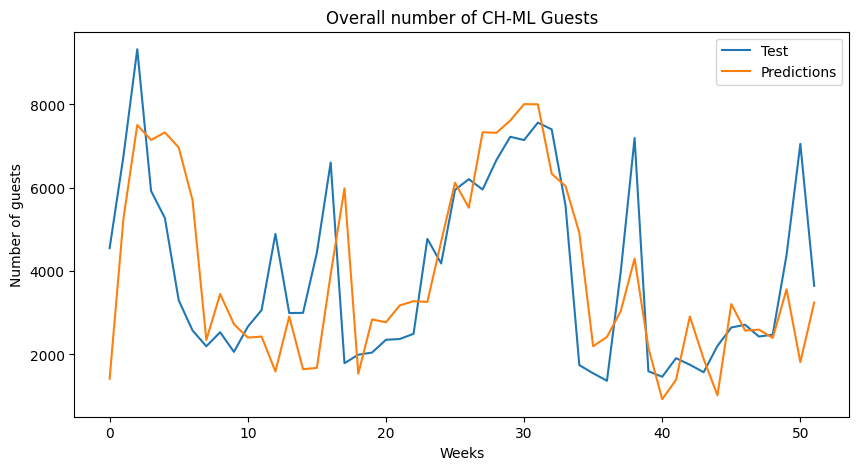

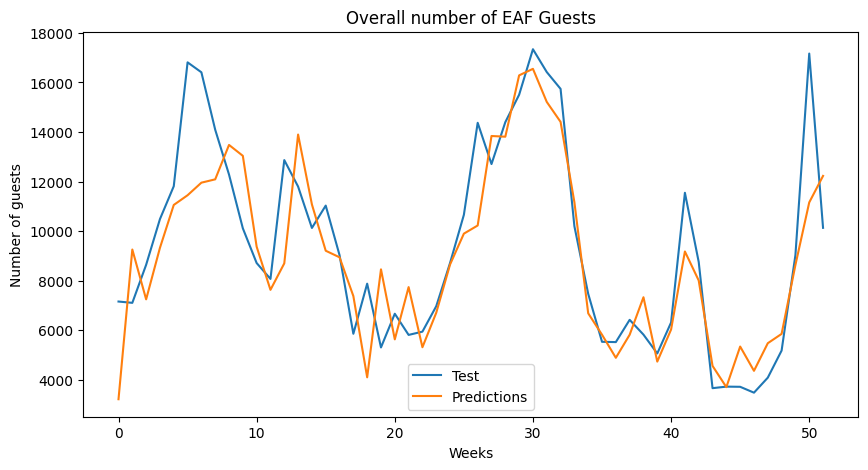

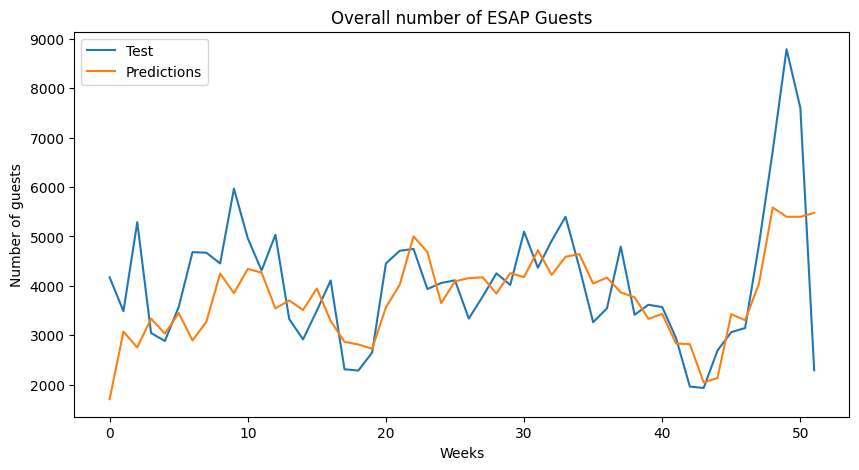

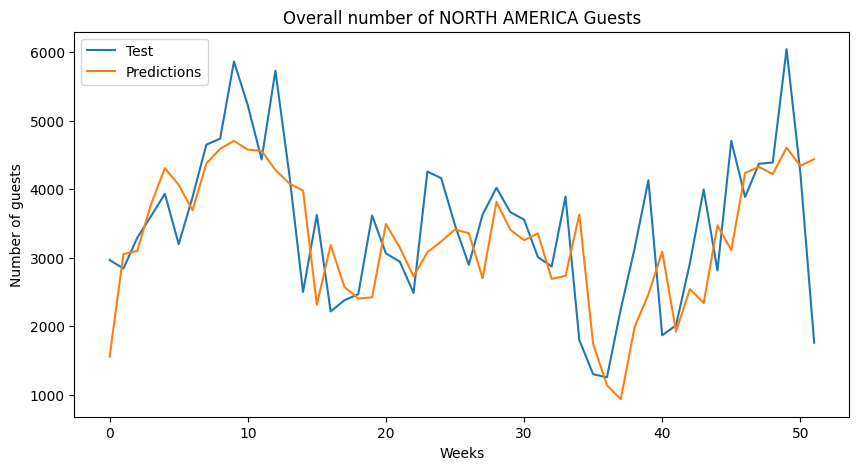

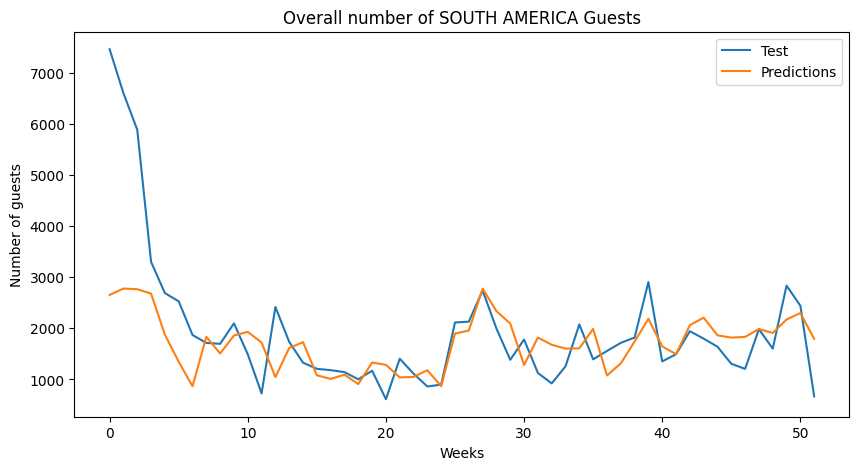

In [51]:
# Plot with LightGBM
plot_feature_categories(df = df_copy, feature = 'business_unit', model=lgb.LGBMRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 100, num_leaves = 31))

## Market predictions

Market = Client origin country

In [52]:
df_copy2 = df.copy()

In [53]:
feature = 'market'

for feature_unit in sorted(df_copy2[feature].unique()):
        print(feature_unit)
        df_feature = df_copy[df_copy[feature] == feature_unit]
        df_agg = process_data(df_feature)

        # Train Test Split
        train,test = split_data(df_agg, split_time)

        # Add time series variables
        train_updated = time_series_var(train)
        test_updated = time_series_var(test)

        # Set up X_train, X_test, y_train, y_test
        # Split intro train and split
        X_train = train_updated.drop(columns = 'nbr_gm')
        X_test = test_updated.drop(columns = 'nbr_gm')

        # Drop "week_ref" column
        X_train = X_train.drop(columns = "week_ref")
        X_test = X_test.drop(columns = "week_ref")

        y_train = train["nbr_gm"]
        y_test = test["nbr_gm"]
       
        print(X_train.shape, y_train.shape)  # Check training set size
        print(X_test.shape, y_test.shape)  # Check test set size


ARGENTINA
(231, 70) (231,)
(52, 70) (52,)
AUSTRALIA
(200, 83) (200,)
(52, 83) (52,)
AUSTRIA
(200, 70) (200,)
(51, 70) (51,)
BALTICS
(109, 54) (109,)
(31, 54) (31,)
BELGIUM
(246, 78) (246,)
(52, 78) (52,)
BRAZIL
(244, 77) (244,)
(52, 77) (52,)
CANADA
(237, 81) (237,)
(52, 81) (52,)
CENTRAL AMERICA
(26, 23) (26,)
(43, 23) (43,)
CHILE
(160, 50) (160,)
(52, 50) (52,)
CHINA MAINLAND
(261, 85) (261,)
(52, 85) (52,)
EAST EUROPE
(64, 54) (64,)
(18, 54) (18,)
FRANCE
(247, 83) (247,)
(52, 83) (52,)
GERMANY
(248, 78) (248,)
(52, 78) (52,)
HONG KONG MARKET
(212, 82) (212,)
(52, 82) (52,)
INDIA
(212, 70) (212,)
(52, 70) (52,)
INDONESIA
(161, 49) (161,)
(50, 49) (50,)
IRELAND
(0, 34) (0,)
(18, 34) (18,)
ISRAEL
(229, 73) (229,)
(51, 73) (51,)
ITALY
(220, 73) (220,)
(52, 73) (52,)
JAPAN
(251, 66) (251,)
(52, 66) (52,)
KOREA
(177, 58) (177,)
(52, 58) (52,)
LEBANON
(174, 65) (174,)
(42, 65) (42,)
MALAYSIA
(204, 69) (204,)
(52, 69) (52,)
MEXICO
(233, 59) (233,)
(52, 59) (52,)
MIDDLE EAST
(165, 69) (165,)

In [54]:
top_10 = df_copy2.groupby(["market"]).agg({'nbr_gm' : "sum"}).sort_values(by="nbr_gm", ascending=False).head(10)

In [55]:
df_copy_filtered = df_copy[df_copy['market'].isin(top_10.index)]

market         RMSE          MAE      MAPE     SMAPE  Total rows
4          FRANCE  1385.110237  1084.209552  0.213940  0.208593          52
9             USA   530.447954   394.512793  0.270726  0.274655          52
5           JAPAN   343.166665   240.190832  0.316376  0.270141          52
2          CANADA   647.159614   511.226266  0.357344  0.355004          52
1          BRAZIL  1061.418322   546.107752  0.368882  0.290304          52
3  CHINA MAINLAND  1721.288787  1259.860018  0.369974  0.340705          52
7       SINGAPORE   449.205538   307.558458  0.396435  0.405130          52
0         BELGIUM   537.920362   370.783155  0.424687  0.359392          52
6        MALAYSIA   382.720866   317.203744  0.546814  0.415971          52
8  UNITED KINGDOM   604.569180   292.300945  0.608318  0.375917          52

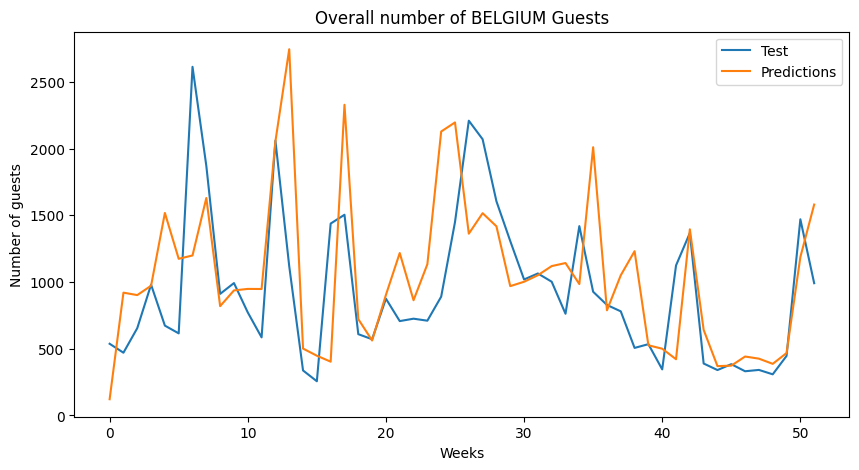

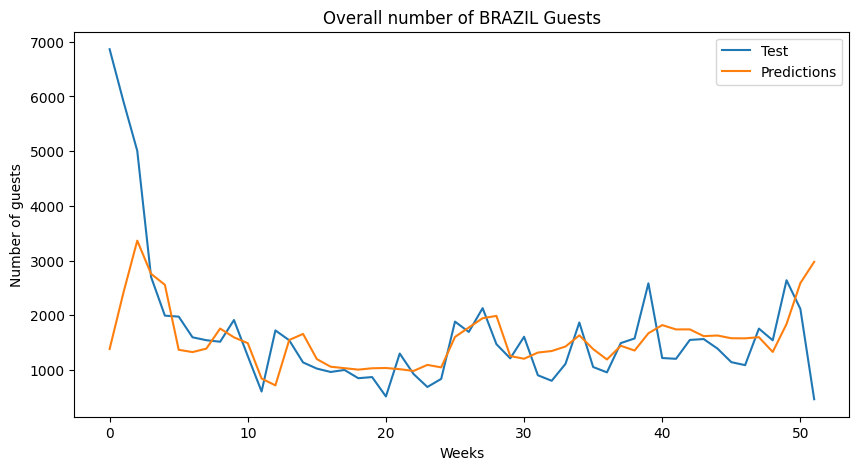

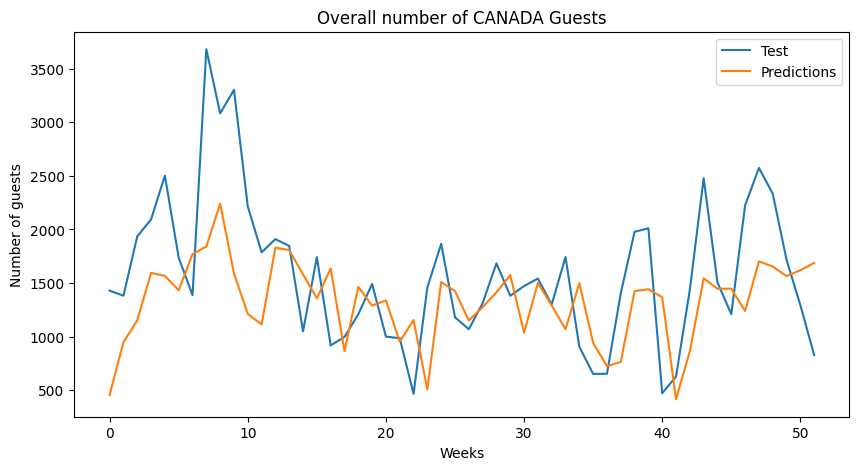

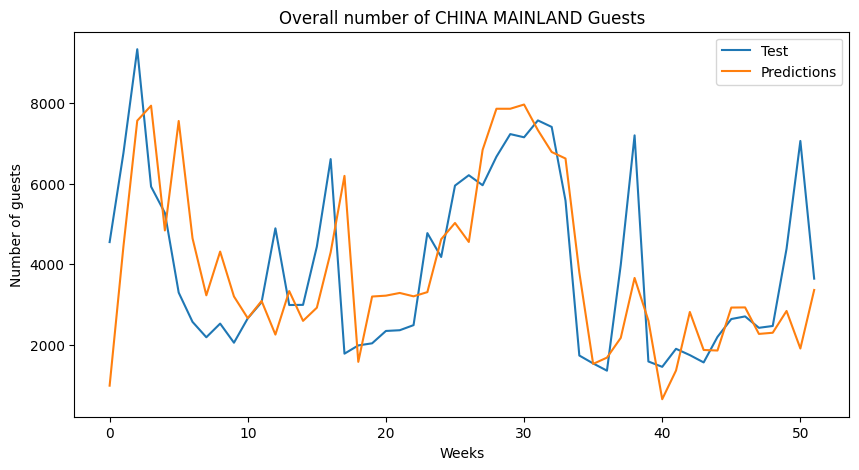

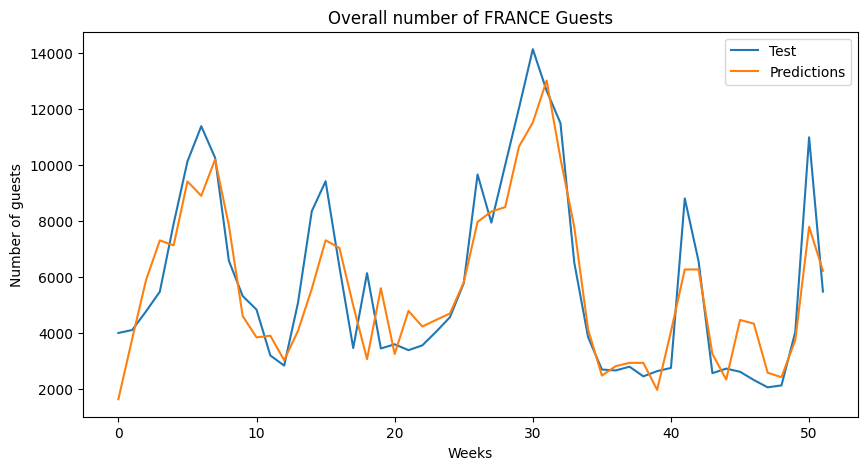

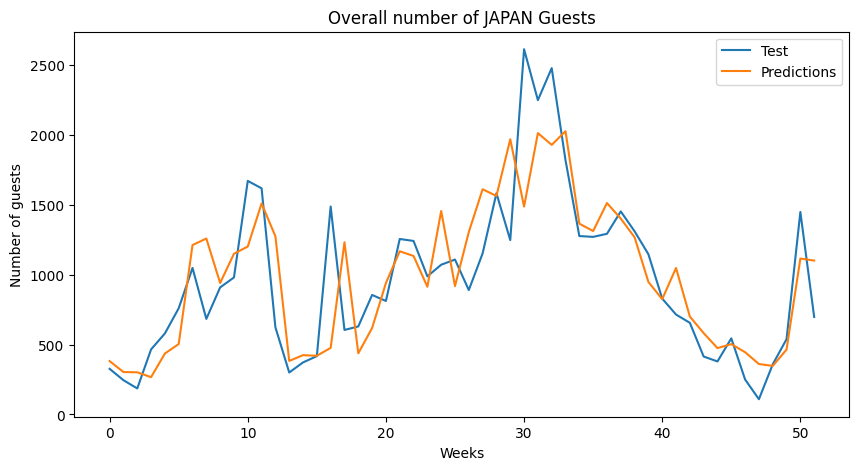

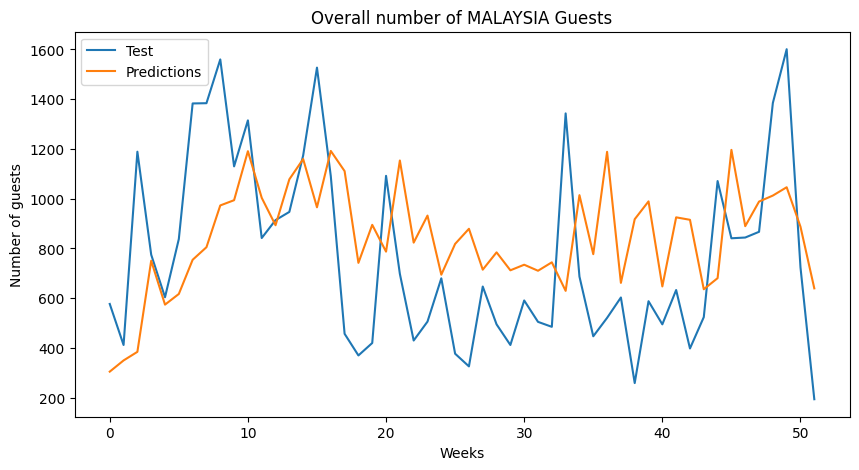

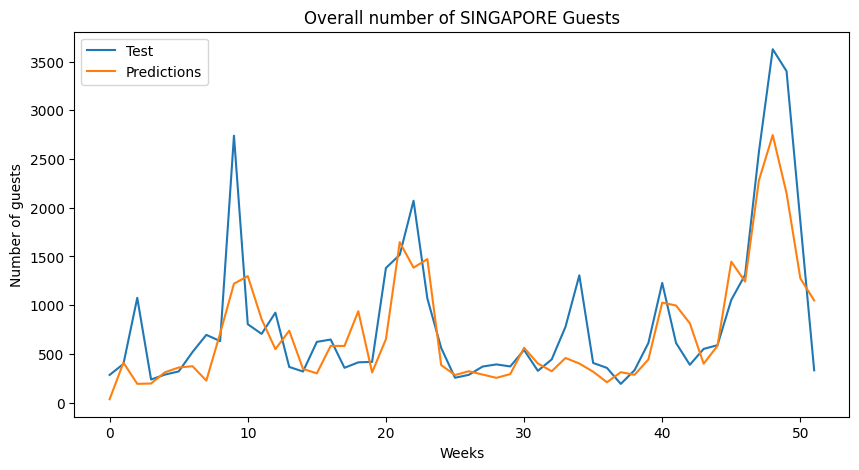

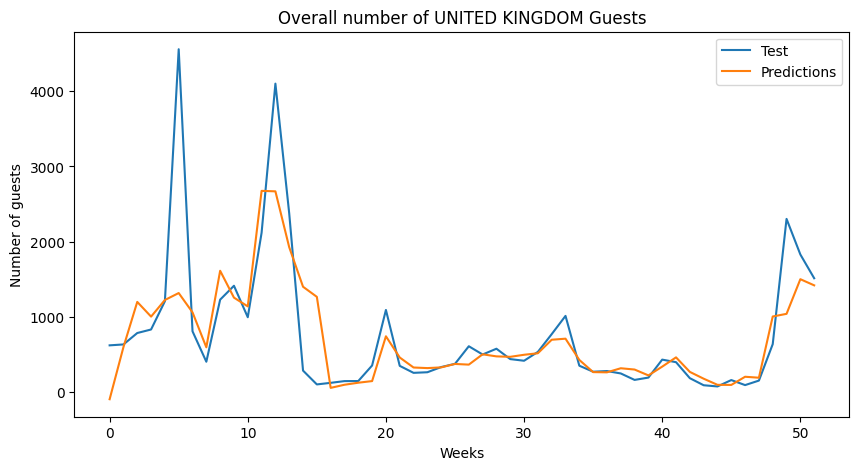

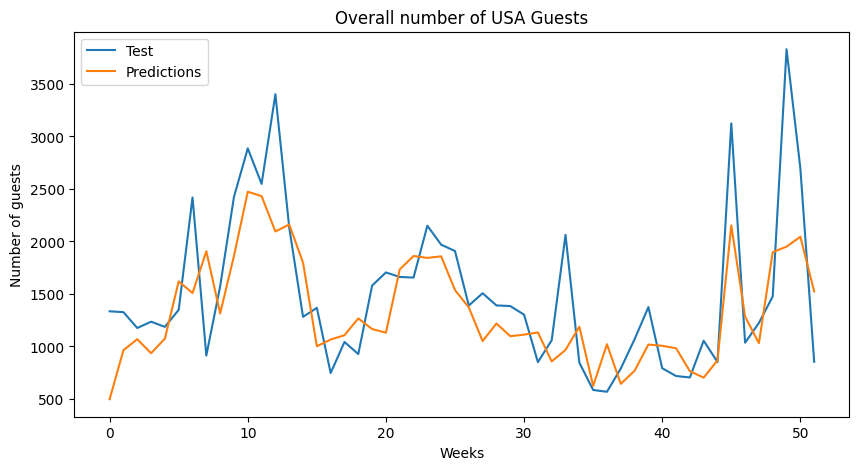

In [56]:
plot_feature_categories(df_copy_filtered, feature = 'market')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 246, number of used features: 7
[LightGBM] [Info] Start training from score 753.788618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

market         RMSE          MAE      MAPE     SMAPE  Total rows
9             USA   536.053163   388.582016  0.275925  0.262131          52
4          FRANCE  1702.515600  1368.142965  0.276598  0.258424          52
2          CANADA   589.197618   459.627125  0.332870  0.326677          52
1          BRAZIL  1060.719548   585.537097  0.350084  0.321253          52
3  CHINA MAINLAND  1724.639618  1256.668198  0.382196  0.351303          52
5           JAPAN   383.237055   288.066005  0.432618  0.329034          52
7       SINGAPORE   553.056843   345.197314  0.481739  0.448423          52
6        MALAYSIA   372.591088   321.361895  0.549490  0.423844          52
8  UNITED KINGDOM   708.641029   358.480440  0.601186  0.482329          52
0         BELGIUM   582.360352   468.204732  0.615765  0.507283          52

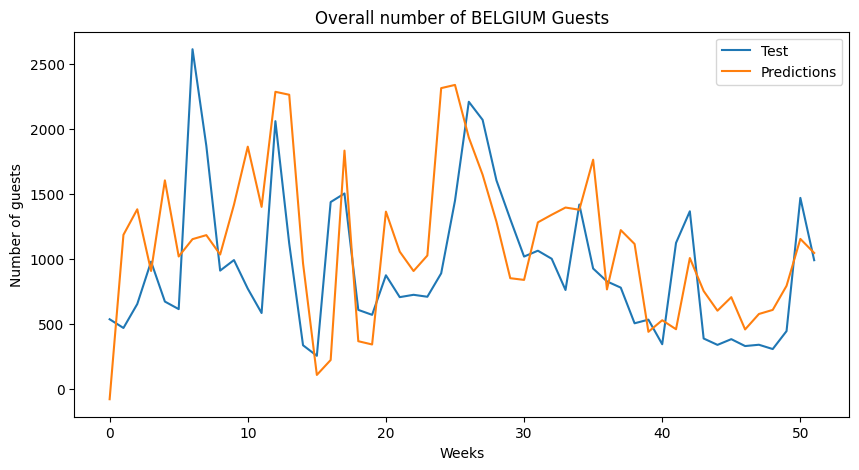

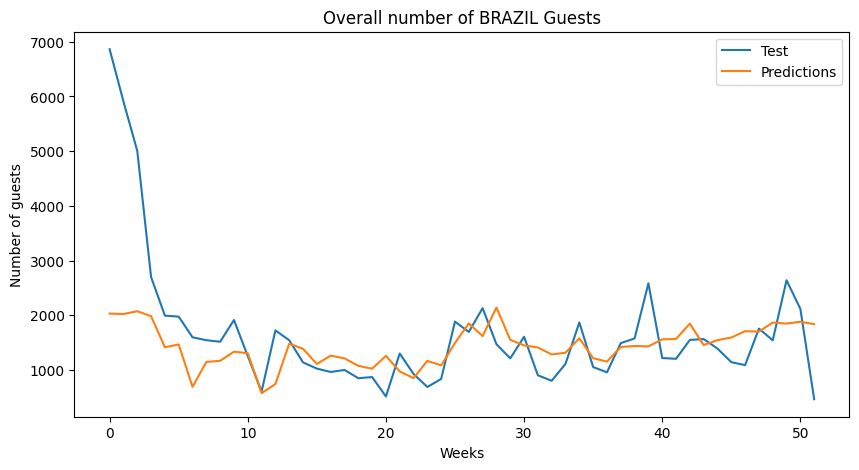

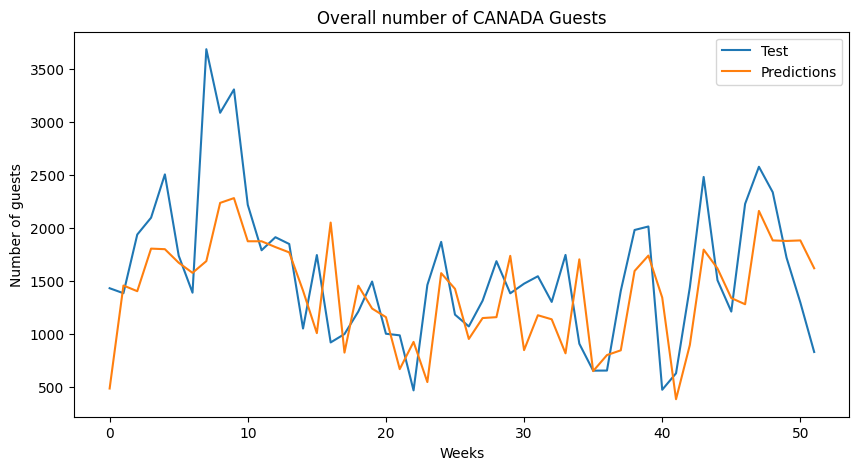

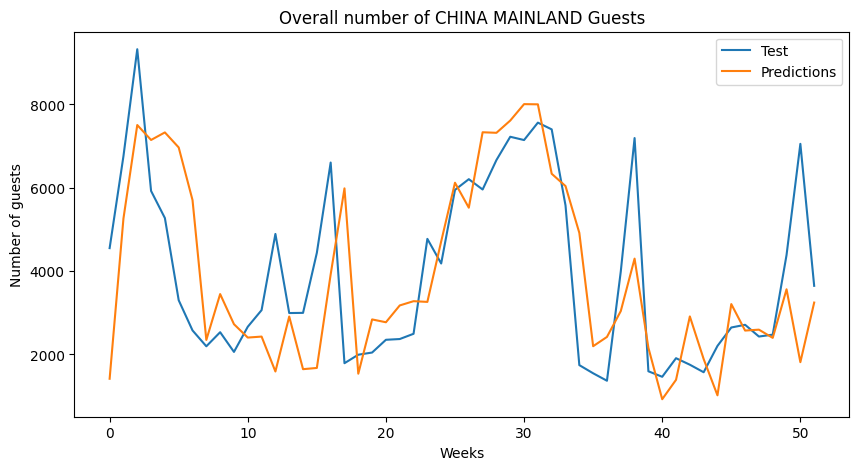

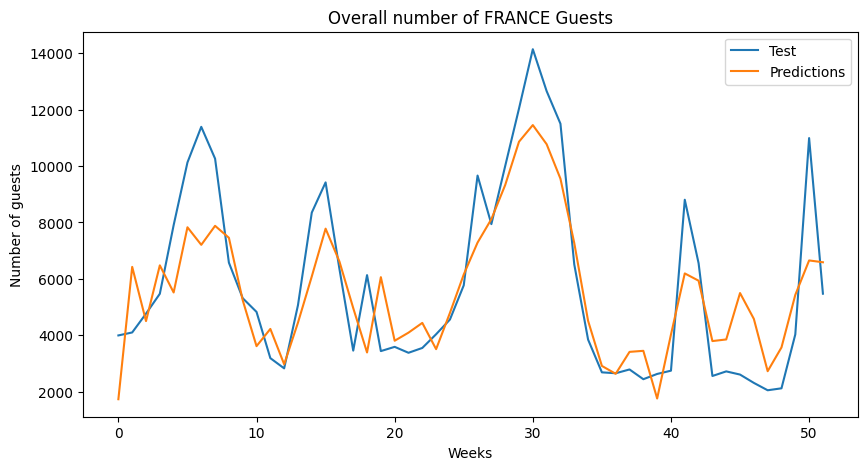

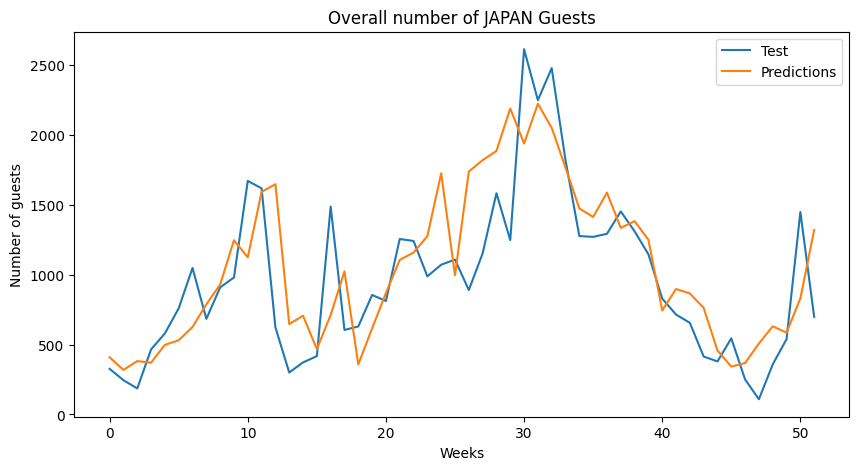

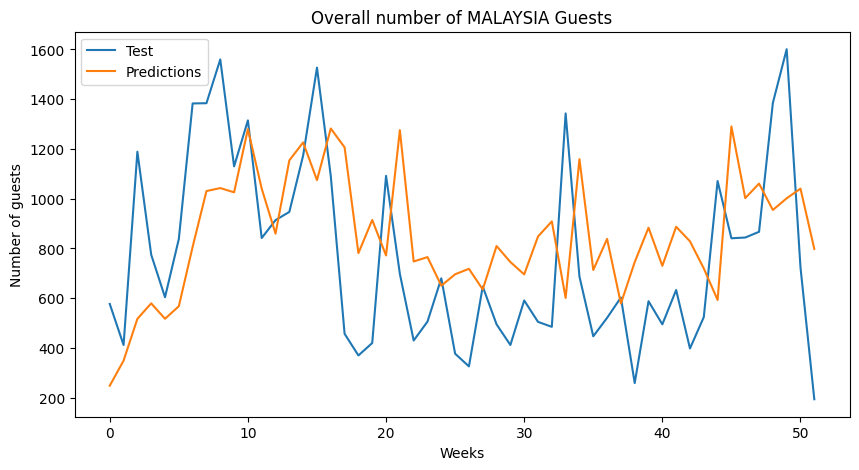

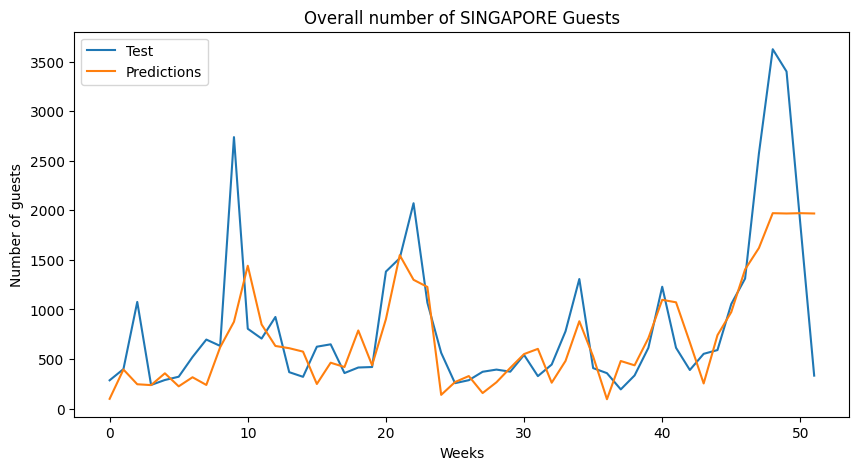

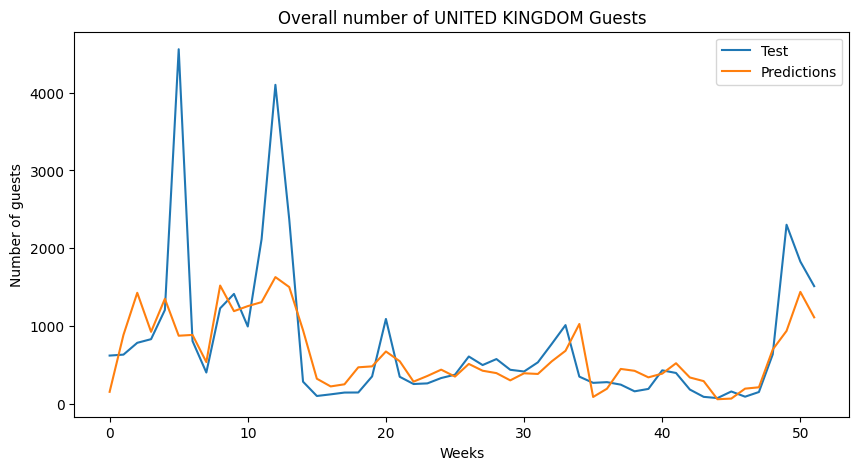

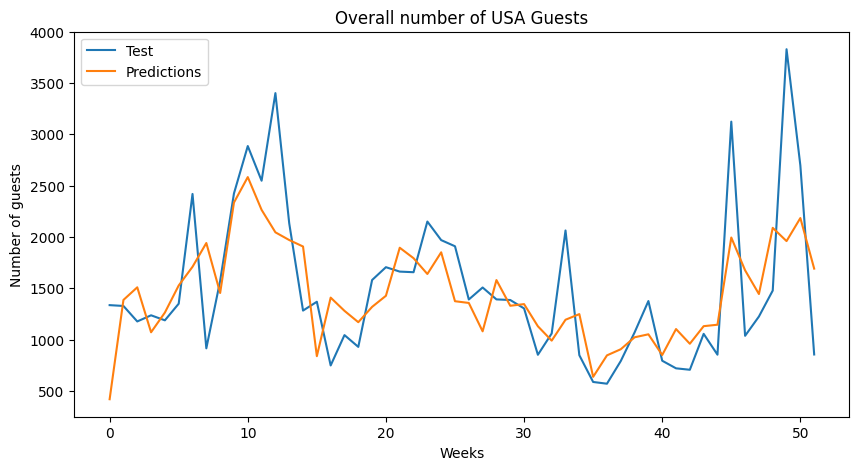

In [57]:
plot_feature_categories(df_copy_filtered, feature = 'market', model=lgb.LGBMRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 100, num_leaves = 31))

## Loyal vs. New Customer

loyal_new         RMSE          MAE      MAPE     SMAPE  Total rows
0     Loyal  1383.721784  1074.488920  0.169111  0.171529          52
1       New  2843.044454  2022.130427  0.177685  0.176186          52

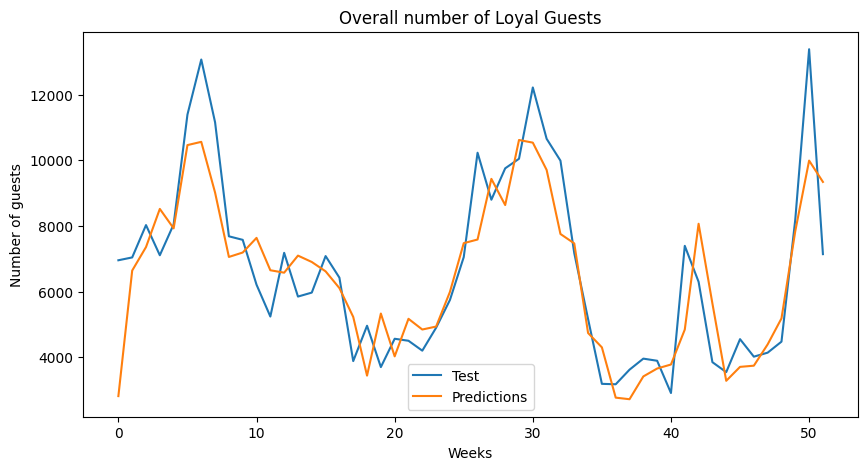

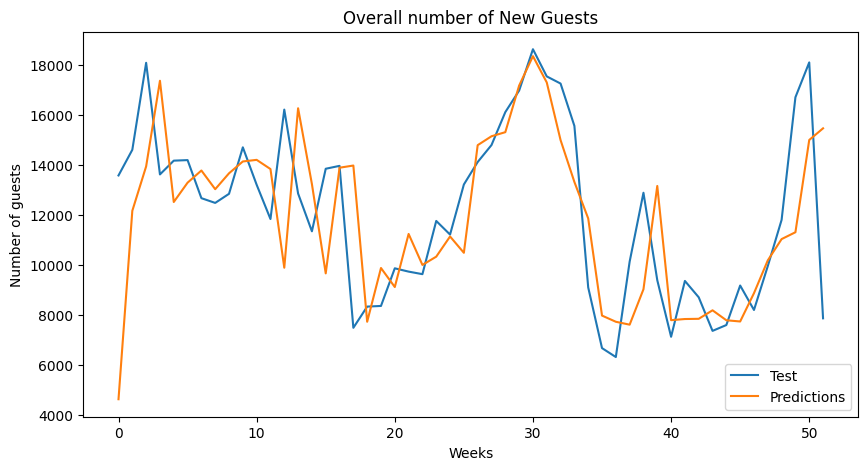

In [58]:
plot_feature_categories(df_copy_filtered, 'loyal_new')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 7
[LightGBM] [Info] Start training from score 5610.765385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

loyal_new         RMSE          MAE      MAPE     SMAPE  Total rows
1       New  3391.593237  2226.307516  0.148696  0.150699          52
0     Loyal  1667.277275  1241.185100  0.165568  0.165041          52

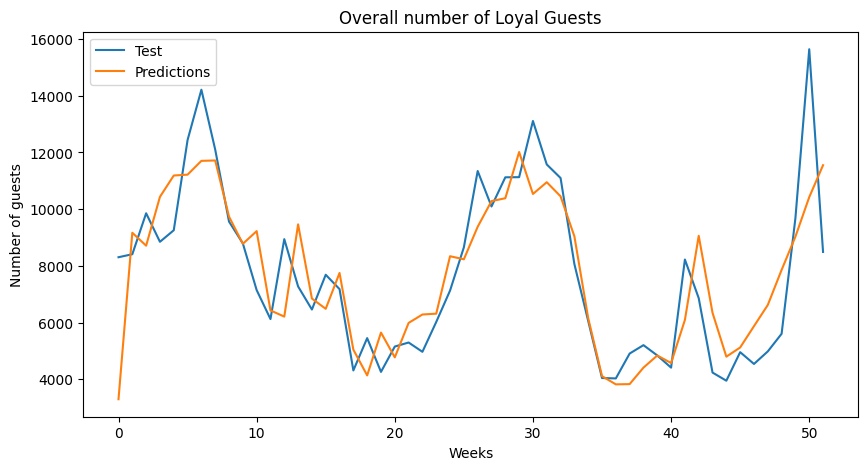

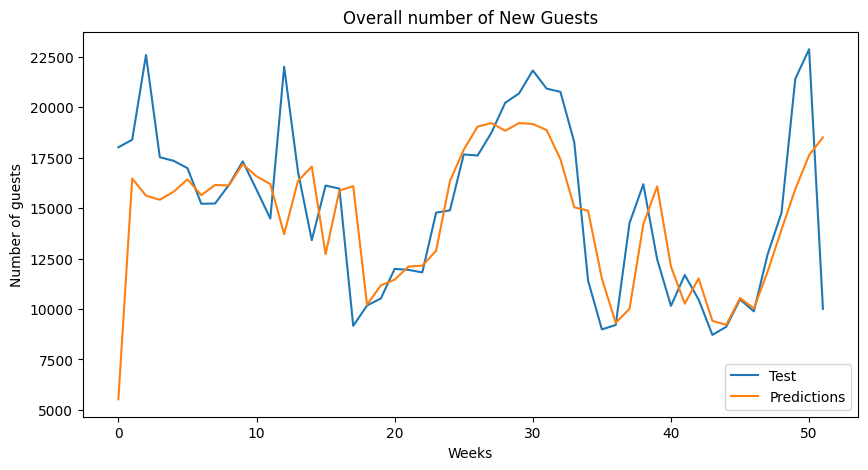

In [59]:
plot_feature_categories(df = df_copy, feature = 'loyal_new', model=lgb.LGBMRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 100, num_leaves = 31))

## Client Type (Family vs. Adult)

client_typo         RMSE          MAE      MAPE     SMAPE  Total rows
0      Adults  1807.753667  1190.428561  0.153314  0.172280          52
1      Family  3017.310043  2443.165771  0.244815  0.252067          52

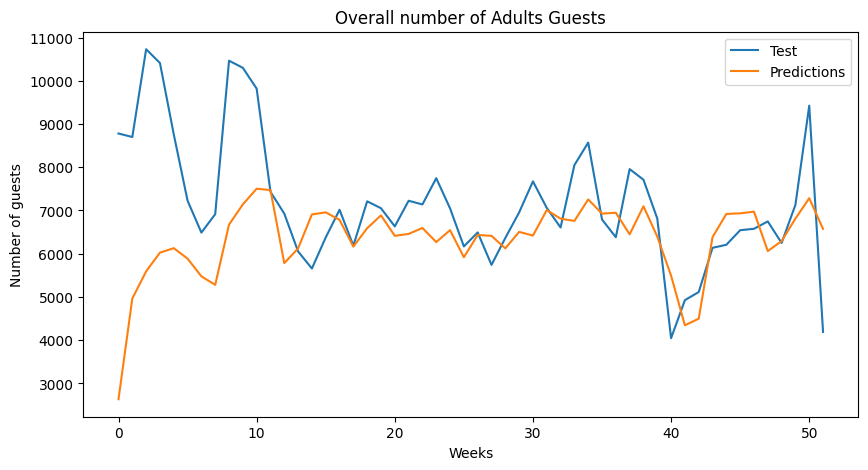

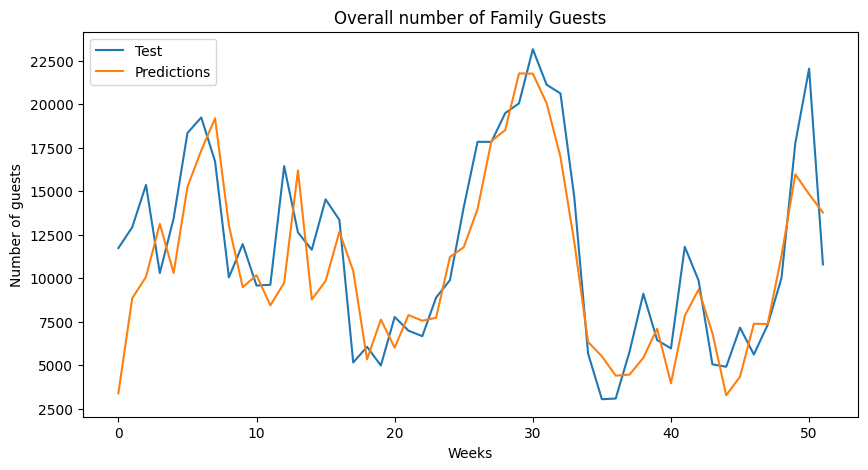

In [60]:
plot_feature_categories(df_copy_filtered, 'client_typo')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 7
[LightGBM] [Info] Start training from score 5266.385496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

client_typo        RMSE          MAE      MAPE     SMAPE  Total rows
0      Adults  1998.01846  1303.276657  0.142140  0.154624          52
1      Family  3580.41427  2737.007554  0.228631  0.208732          52

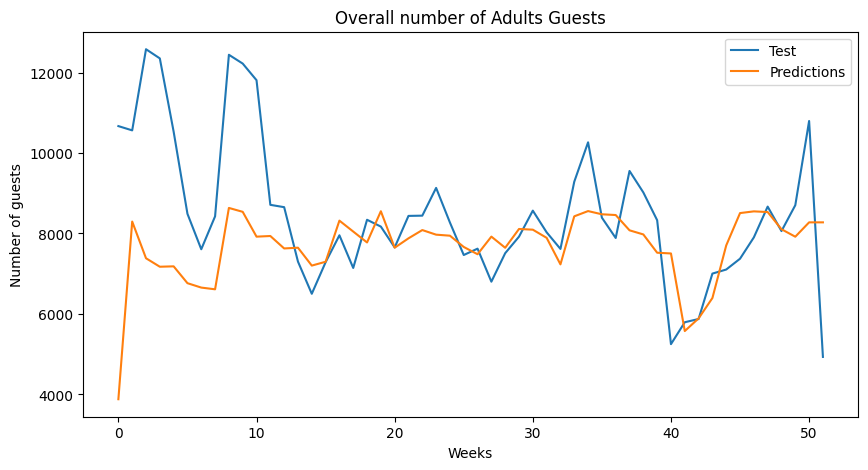

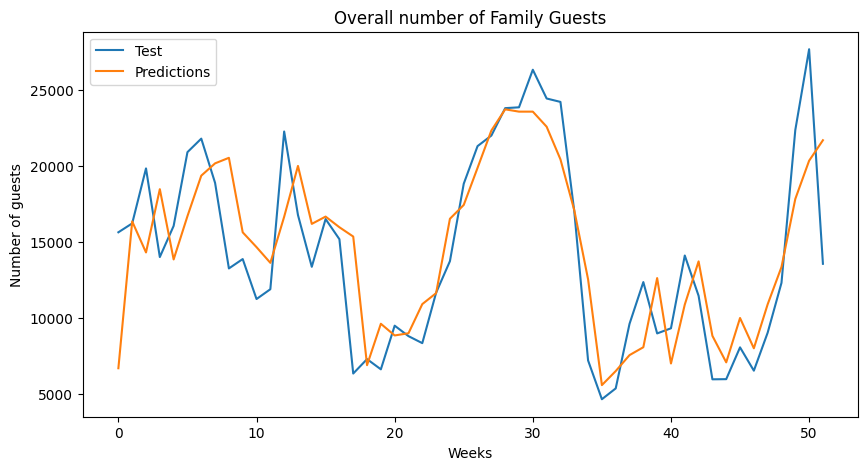

In [61]:
plot_feature_categories(df = df_copy, feature = 'client_typo', model=lgb.LGBMRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 100, num_leaves = 31))

## Resort Sector
The geographical sector where the resort is located

C:\Users\manuc\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


sector_resort         RMSE         MAE      MAPE  \
3  EUROPE AFRICA SEA & COUNTRYSIDE   798.481373  582.681749  0.207105   
6                    NORTH AMERICA   964.987547  709.602079  0.213389   
1                         ASIA SUN  1018.899367  810.270041  0.280964   
5                          JOYVIEW   928.573843  589.027083  0.289284   
7                    SOUTH AMERICA   472.033130  347.807217  0.859330   
8                      URBAN OASIS  1017.613876  869.833333  1.000000   
0                    ASIA MOUNTAIN   782.642135  482.040951  1.040201   
2                     CLUB MED TWO    85.174973   68.944332  1.427817   
4                  EUROPE MOUNTAIN  1539.040616  973.393201  2.754495   

      SMAPE  Total rows  
3  0.195851          52  
6  0.200996          52  
1  0.254319          52  
5  0.297503          52  
7  0.286966          52  
8  2.000000          12  
0  0.472453          47  
2  0.399683          44  
4  0.398273          39

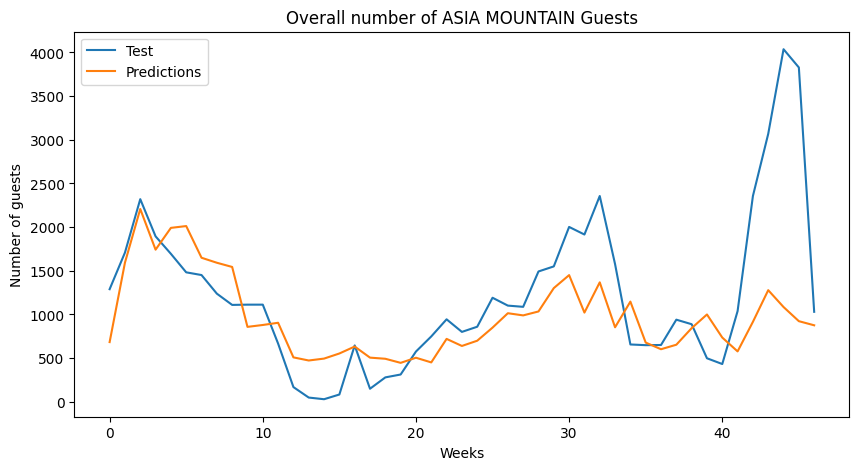

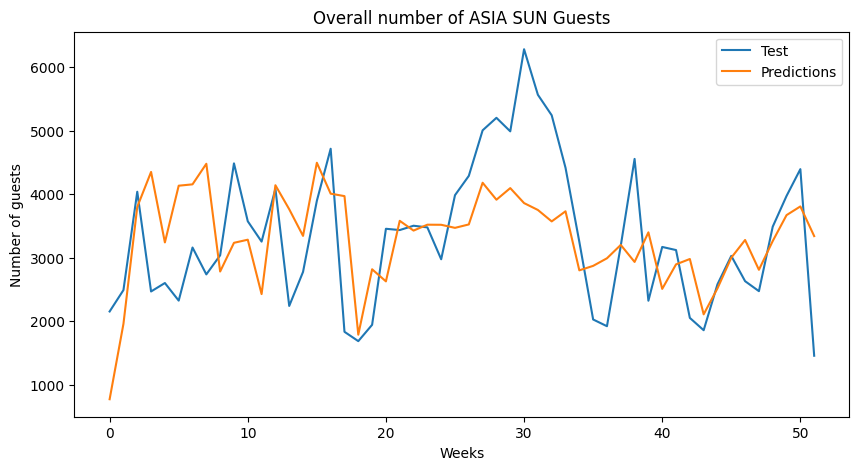

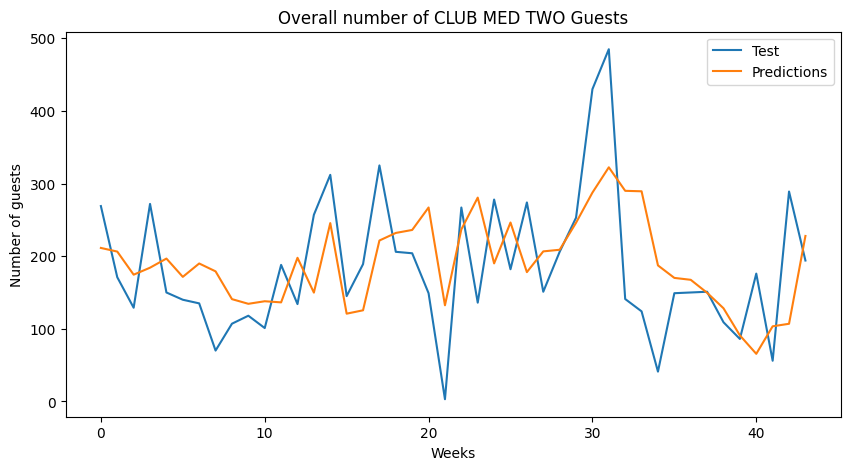

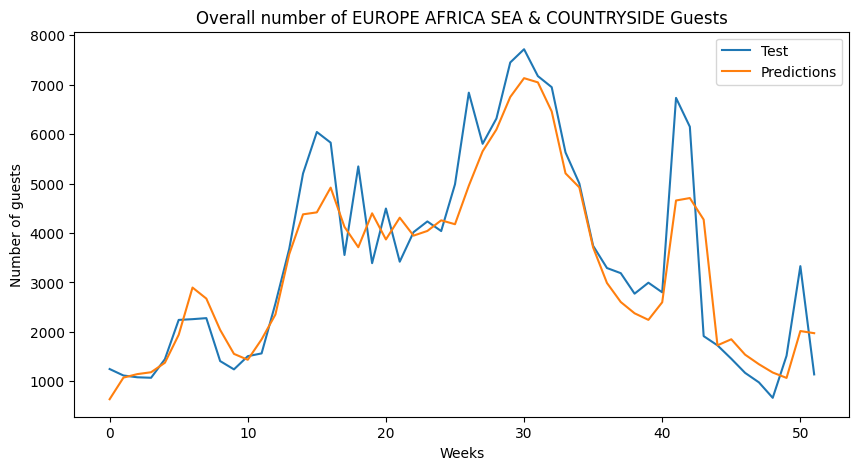

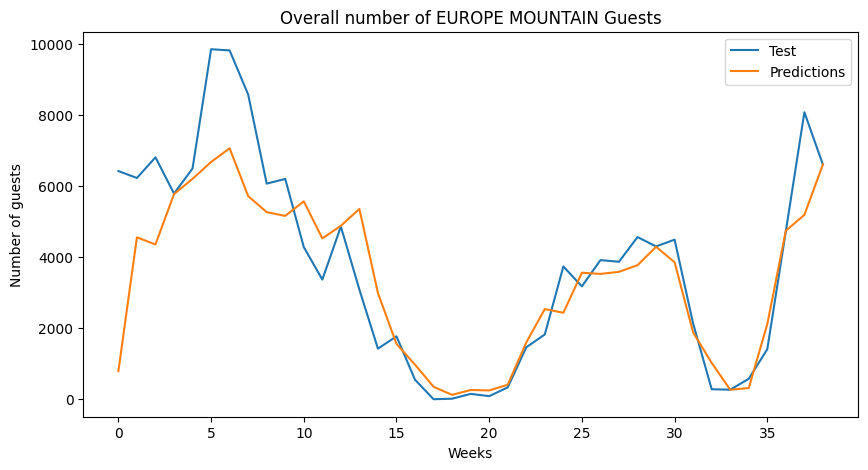

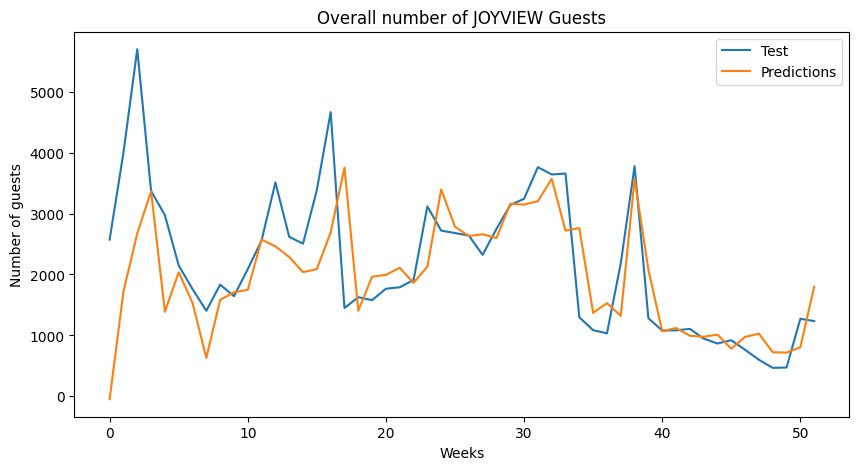

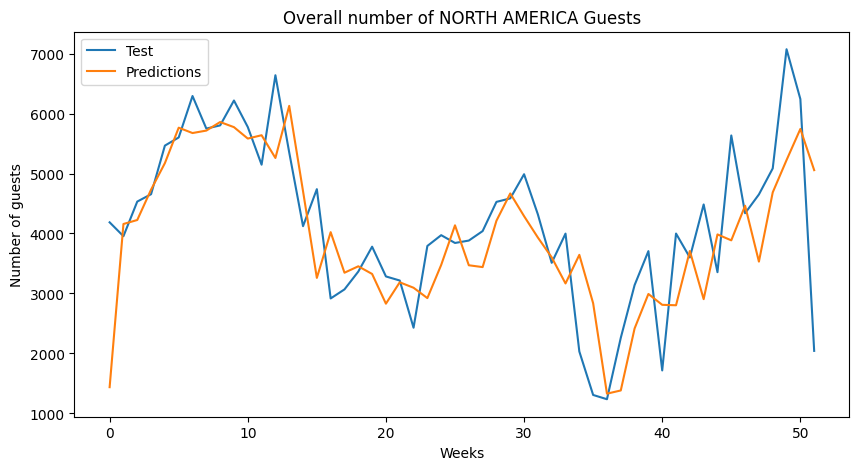

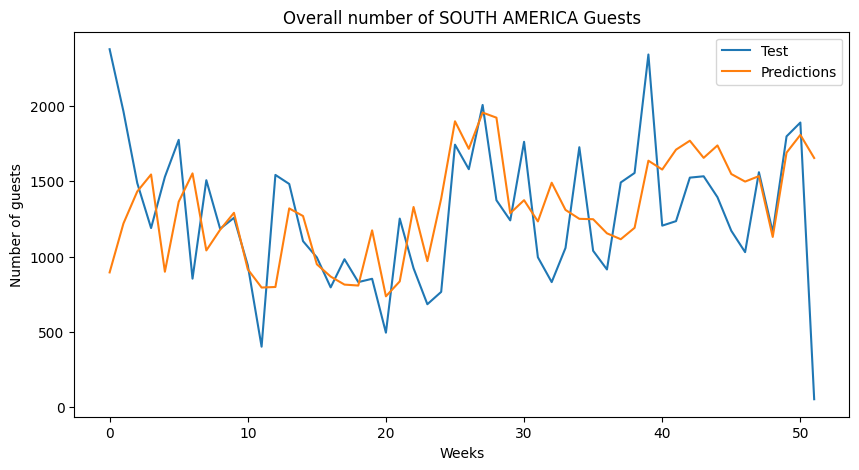

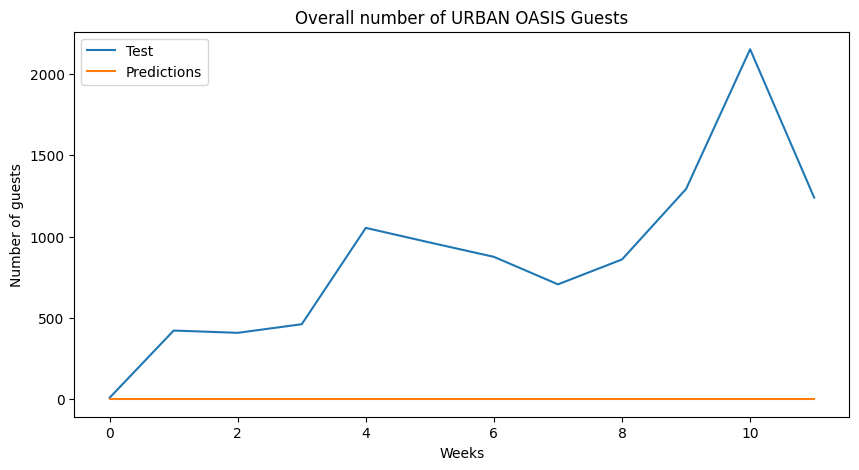

In [62]:
plot_feature_categories(df_copy_filtered, 'sector_resort')

## Predicting the Future
1. Step by step set up for future prediciton
2. Consolidated format (using functions)

### 1. Step by step set up for future predictions

In [63]:
# Create a copy for practice
df_play = df_copy.copy()

In [64]:
# Aggregate data globaly
df_agg = df_play.groupby(["week_ref","year","month","week"]).agg({'nbr_gm' : "sum"}).reset_index()

In [65]:
# Generate a dataframe for next 6 months
from datetime import timedelta
date_range = [df_agg["week_ref"].max() + timedelta(days = 7*i) for i in range(26)]
future_df = pd.DataFrame(date_range, columns = ["week_ref"])
future_df['isFuture'] = True

In [66]:
# Add time features to df_agg
df_trial = time_series_var(df_agg)

In [67]:
df_trial.tail()

week_ref  year  month  week  nbr_gm  week_lag_1  week_lag_2  \
309 2023-12-02  2023     12    48   17695     14425.0     15432.0   
310 2023-12-09  2023     12    49   20368     17695.0     14425.0   
311 2023-12-16  2023     12    50   31081     20368.0     17695.0   
312 2023-12-23  2023     12    51   38501     31081.0     20368.0   
313 2023-12-30  2023     12    52   18497     38501.0     31081.0   

     rolling_mean  fourier_transform  
309  15853.333333       1.079735e+05  
310  16193.444444       6.055749e+04  
311  18028.666667       3.135004e+05  
312  20094.888889       5.651673e+05  
313  20224.666667       1.019707e+06

In [68]:
df_trial_train = df_trial[:-10]
df_trial_train_X = df_trial_train.drop(columns =["week_ref", "nbr_gm"] )
df_trial_train_y = df_trial_train["nbr_gm"]
df_trial_test = df_trial[-10:]
df_trial_test_X = df_trial_test.drop(columns =["week_ref", "nbr_gm"] )
df_trial_test_y = df_trial_test["nbr_gm"]
reg.fit(df_trial_train_X,df_trial_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Manual attempt (for loop)

In [69]:
import pandas as pd

# Define the starting date
start_date = "2023-12-02"

# Generate a date range starting from `start_date` for the next 5 intervals, with each step being 7 days
date_range = pd.date_range(start=start_date, periods=5, freq='7D')

# Create a DataFrame with the date range
df_future_dates = pd.DataFrame(date_range, columns=['week_ref'])

df_future_dates



week_ref
0 2023-12-02
1 2023-12-09
2 2023-12-16
3 2023-12-23
4 2023-12-30

In [70]:
# Date decomposition
weekref_breakdown(df_future_dates)

week_ref  year  month  week
0 2023-12-02  2023     12    48
1 2023-12-09  2023     12    49
2 2023-12-16  2023     12    50
3 2023-12-23  2023     12    51
4 2023-12-30  2023     12    52

In [71]:
df_future_dates.iloc[0].values

array([Timestamp('2023-12-02 00:00:00'), 2023, 12, 48], dtype=object)

In [72]:
# Concatenate the original DataFrame with the future dates DataFrame
df_old_dates = df_trial.iloc[:-5,:]
df_combined = pd.concat([df_old_dates, df_future_dates.iloc[0:1]], ignore_index=True)

df_combined.tail(10)


week_ref  year  month  week   nbr_gm  week_lag_1  week_lag_2  \
300 2023-09-30  2023      9    39  21380.0     19162.0     13241.0   
301 2023-10-07  2023     10    40  17307.0     21380.0     19162.0   
302 2023-10-14  2023     10    41  14564.0     17307.0     21380.0   
303 2023-10-21  2023     10    42  19905.0     14564.0     17307.0   
304 2023-10-28  2023     10    43  17329.0     19905.0     14564.0   
305 2023-11-04  2023     11    44  12956.0     17329.0     19905.0   
306 2023-11-11  2023     11    45  13067.0     12956.0     17329.0   
307 2023-11-18  2023     11    46  15432.0     13067.0     12956.0   
308 2023-11-25  2023     11    47  14425.0     15432.0     13067.0   
309 2023-12-02  2023     12    48      NaN         NaN         NaN   

     rolling_mean  fourier_transform  
300  23317.222222      200336.619529  
301  21360.111111       68268.353844  
302  19368.666667      853347.181844  
303  18041.555556       79564.694420  
304  17042.777778      211104.979538  
305  16542.000000       94652.448721  
306  16545.666667      272928.543209  
307  16789.111111      271622.895127  
308  16262.777778       25691.809434  
309           NaN                NaN

In [73]:
df_combined = time_series_var(df_combined)
df_combined.tail()

week_ref  year  month  week   nbr_gm  week_lag_1  week_lag_2  \
305 2023-11-04  2023     11    44  12956.0     17329.0     19905.0   
306 2023-11-11  2023     11    45  13067.0     12956.0     17329.0   
307 2023-11-18  2023     11    46  15432.0     13067.0     12956.0   
308 2023-11-25  2023     11    47  14425.0     15432.0     13067.0   
309 2023-12-02  2023     12    48      NaN     14425.0     15432.0   

     rolling_mean  fourier_transform  
305  16542.000000      129484.990974  
306  16545.666667       25598.215737  
307  16789.111111      308777.095938  
308  16262.777778      583000.618427  
309           NaN      981321.804215

In [74]:
# Predict the target for new row then replace value
model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 200)

# Create a copy
df_co_copy = df_combined.copy().drop(columns = 'week_ref')
X_train = df_co_copy.drop(columns = 'nbr_gm')
y_train = df_co_copy['nbr_gm']

# Fit model
model.fit(X_train.iloc[:-1], y_train[:-1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

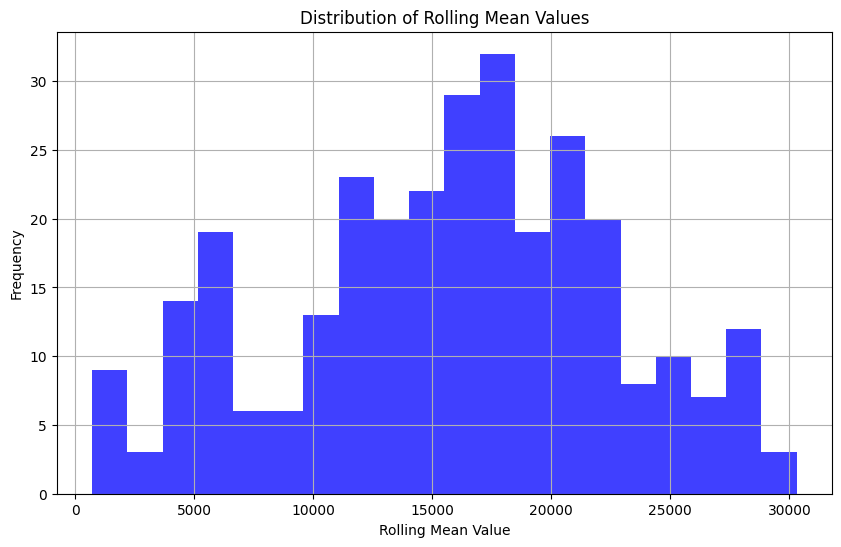

In [75]:
# Get an understanding for rolling mean to fill the NA values

import matplotlib.pyplot as plt

# Plotting the histogram for the 'rolling_mean' column
plt.figure(figsize=(10, 6))  
plt.hist(X_train['rolling_mean'].dropna(), bins=20, alpha=0.75, color='blue')  

plt.title('Distribution of Rolling Mean Values')  # Title of the histogram
plt.xlabel('Rolling Mean Value')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis

plt.grid(True)  # Optional: Show grid for better readability
plt.show()


In [76]:
# Since we have a relatively evenly distrubted 'rolling_mean' value, we will proceed with filling the NaN with the mean

# Calc mean of rolling_mean to fill NaN
mean_value = X_train['rolling_mean'].mean()

# Fill
X_train.iloc[-1] = X_train.iloc[-1].fillna(mean_value)

In [77]:
X_last_row = X_train.iloc[-1].values.reshape(1, -1).astype(float)

In [78]:
X_last_row

array([[2.02300000e+03, 1.20000000e+01, 4.80000000e+01, 1.44250000e+04,
        1.54320000e+04, 1.57177434e+04, 9.81321804e+05]])

In [79]:
# Y-pred
y_hat = model.predict(X_last_row)

In [80]:
# Replace the nbr_gm with y_hat
new_values = {"nbr_gm": y_hat}
df_combined.loc[df_combined.index[-1], new_values.keys()] = new_values.values()

In [81]:
df_combined.tail()

week_ref  year  month  week        nbr_gm  week_lag_1  week_lag_2  \
305 2023-11-04  2023     11    44  12956.000000     17329.0     19905.0   
306 2023-11-11  2023     11    45  13067.000000     12956.0     17329.0   
307 2023-11-18  2023     11    46  15432.000000     13067.0     12956.0   
308 2023-11-25  2023     11    47  14425.000000     15432.0     13067.0   
309 2023-12-02  2023     12    48  18282.494141     14425.0     15432.0   

     rolling_mean  fourier_transform  
305  16542.000000      129484.990974  
306  16545.666667       25598.215737  
307  16789.111111      308777.095938  
308  16262.777778      583000.618427  
309           NaN      981321.804215

In [82]:
time_series_var(df_combined)

week_ref  year  month  week        nbr_gm  week_lag_1  week_lag_2  \
0   2017-12-30  2017     12    52   6452.000000         NaN         NaN   
1   2018-01-06  2018      1     1  14425.000000      6452.0         NaN   
2   2018-01-13  2018      1     2  16271.000000     14425.0      6452.0   
3   2018-01-20  2018      1     3  18952.000000     16271.0     14425.0   
4   2018-01-27  2018      1     4  19110.000000     18952.0     16271.0   
..         ...   ...    ...   ...           ...         ...         ...   
305 2023-11-04  2023     11    44  12956.000000     17329.0     19905.0   
306 2023-11-11  2023     11    45  13067.000000     12956.0     17329.0   
307 2023-11-18  2023     11    46  15432.000000     13067.0     12956.0   
308 2023-11-25  2023     11    47  14425.000000     15432.0     13067.0   
309 2023-12-02  2023     12    48  18282.494141     14425.0     15432.0   

     rolling_mean  fourier_transform  
0             NaN       4.872478e+06  
1             NaN       9.850915e+05  
2             NaN       5.793904e+05  
3             NaN       3.099973e+05  
4             NaN       2.921235e+04  
..            ...                ...  
305  16542.000000       1.256733e+05  
306  16545.666667       2.921235e+04  
307  16789.111111       3.099973e+05  
308  16262.777778       5.793904e+05  
309  15918.610460       9.850915e+05  

[310 rows x 9 columns]

### 2. Consolidated format (using functions)

In [83]:
# Predict the last 26 weeks of 2024 and compare against test set
df_trial["week_ref"][-26:]

288   2023-07-08
289   2023-07-15
290   2023-07-22
291   2023-07-29
292   2023-08-05
293   2023-08-12
294   2023-08-19
295   2023-08-26
296   2023-09-02
297   2023-09-09
298   2023-09-16
299   2023-09-23
300   2023-09-30
301   2023-10-07
302   2023-10-14
303   2023-10-21
304   2023-10-28
305   2023-11-04
306   2023-11-11
307   2023-11-18
308   2023-11-25
309   2023-12-02
310   2023-12-09
311   2023-12-16
312   2023-12-23
313   2023-12-30
Name: week_ref, dtype: datetime64[ns]

In [84]:
def create_future_dates(start_date, weeks, week_breakdown = True):
    """
    Creates a new dataframe based on start_date and requested weeks
    """
    # Define the starting date
    start_date = start_date

    # Generate a date range starting from `start_date` for the next 5 intervals, with each step being 7 days
    date_range = pd.date_range(start=start_date, periods=weeks, freq='7D')

    # Create a DataFrame with the date range
    df_future_dates = pd.DataFrame(date_range, columns=['week_ref'])

    # Create breakdown
    if week_breakdown:
        # Date decomposition
        weekref_breakdown(df_future_dates)

    return df_future_dates


In [85]:
df_futures = create_future_dates(start_date = "2023-07-08", weeks = 26)

In [86]:
df_futures

week_ref  year  month  week
0  2023-07-08  2023      7    27
1  2023-07-15  2023      7    28
2  2023-07-22  2023      7    29
3  2023-07-29  2023      7    30
4  2023-08-05  2023      8    31
5  2023-08-12  2023      8    32
6  2023-08-19  2023      8    33
7  2023-08-26  2023      8    34
8  2023-09-02  2023      9    35
9  2023-09-09  2023      9    36
10 2023-09-16  2023      9    37
11 2023-09-23  2023      9    38
12 2023-09-30  2023      9    39
13 2023-10-07  2023     10    40
14 2023-10-14  2023     10    41
15 2023-10-21  2023     10    42
16 2023-10-28  2023     10    43
17 2023-11-04  2023     11    44
18 2023-11-11  2023     11    45
19 2023-11-18  2023     11    46
20 2023-11-25  2023     11    47
21 2023-12-02  2023     12    48
22 2023-12-09  2023     12    49
23 2023-12-16  2023     12    50
24 2023-12-23  2023     12    51
25 2023-12-30  2023     12    52

In [87]:
def concat_old_future(df_old, df_future, weeks):

    """
    Creates a multi-step forecast for the amount of weeks requested
    df_old: Refers to dataset of old dates
    weeks: should match the amount of weeks you are predicting/testing
    """  
    # Concat old and new time series
    df_old_cut = df_old.iloc[:-weeks,:]
    df_combined = pd.concat([df_old_cut, df_future], ignore_index=True)

    # Fill in time series variables
    df_combined = time_series_var(df_combined)

    return df_combined


In [88]:
df_combined = concat_old_future(df_old = df_trial, df_future = df_futures, weeks = 26)

In [89]:
# Predict the target for new row then replace value

model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 1000)
# model=lgb.LGBMRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 100, num_leaves = 31)

for i in range(0,26):    
    # Create a copy
    df_co_copy = df_combined.copy().drop(columns = 'week_ref')
    X_train = df_co_copy.drop(columns = 'nbr_gm')
    y_train = df_co_copy['nbr_gm']

    # Fit model [:-weeks+i]
    model.fit(X_train.iloc[:-26+i], y_train[:-26+i])

        # Fill NaN values with mode

    # Calc mean of rolling_mean to fill NaN
    mean_value = X_train['rolling_mean'].mean()

    # Fill
    X_train.iloc[-26+i] = X_train.iloc[-26+i].fillna(mean_value)

    # Reshape to use in prediction
    X_last_row = X_train.iloc[-26+i].values.reshape(1, -1).astype(float)

    # Y-pred
    y_hat = model.predict(X_last_row)

    # Replace the nbr_gm with y_hat
    new_values = {"nbr_gm": y_hat}
    df_combined.loc[df_combined.index[-26+i], new_values.keys()] = new_values.values()

    # Recalc 
    df_combined = time_series_var(df_combined)

In [90]:
y_test = df_trial['nbr_gm'][-26:]
y_preds = df_combined['nbr_gm'][-26:]

# Reset index 
y_test_reset = y_test.reset_index(drop=True)
y_preds_reset = y_preds.reset_index(drop=True)

comparison_df = pd.DataFrame({'Actual': y_test_reset, 'Predicted': y_preds_reset})
comparison_df[:13]

Actual     Predicted
0    28943  26653.185547
1    28818  29287.466797
2    31332  29323.166016
3    31798  29594.175781
4    34921  28003.666016
5    32487  29080.125000
6    31849  29251.220703
7    26318  26545.933594
8    17463  22372.382812
9    13034  19287.769531
10   13241  18738.214844
11   19162  18901.070312
12   21380  17376.654297

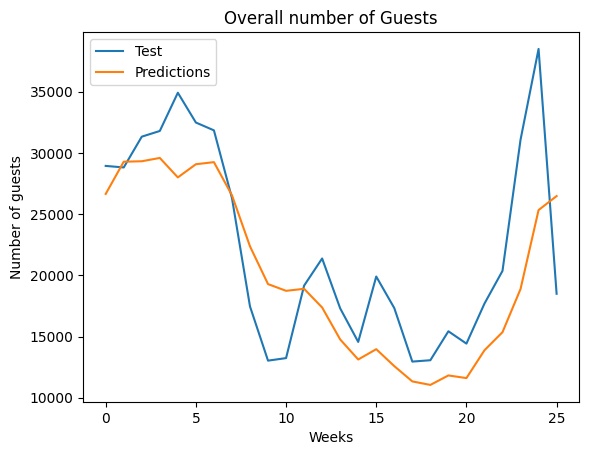

In [91]:
# Plot time series
# plt.plot(X_train.index, y_train, label = "Train")
plt.plot(comparison_df["Actual"].values, label = "Test")
plt.plot(comparison_df["Predicted"].values, label = "Predictions")

plt.xlabel("Weeks")
plt.ylabel("Number of guests")
plt.title("Overall number of Guests")
plt.legend()

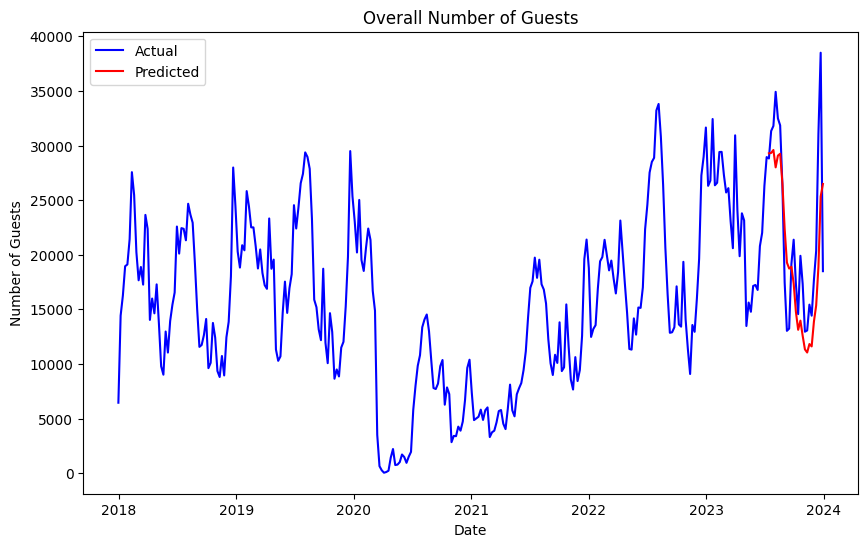

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

comparison_df = df_combined.copy()
comparison_trial_df = df_trial.copy()
# Assuming comparison_df is your DataFrame and 'week_ref' is the column with dates
# Convert 'week_ref' to datetime
comparison_df['week_ref'] = pd.to_datetime(comparison_df['week_ref'])
comparison_trial_df['week_ref'] = pd.to_datetime(comparison_df['week_ref'])

# Set 'week_ref' as the index of the DataFrame
comparison_df.set_index('week_ref', inplace=True)

# Set 
comparison_trial_df.set_index('week_ref', inplace=True)

# Now, proceed with the plotting
cutoff_date = pd.to_datetime("2023-07-08")
data_before = comparison_df[comparison_df.index <= cutoff_date]
data_after = comparison_df[comparison_df.index > cutoff_date]

plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

plt.plot(comparison_trial_df.index, comparison_trial_df["nbr_gm"].values, label="Actual", color='blue')
plt.plot(data_after.index, data_after["nbr_gm"].values, label="Predicted", color='red')

plt.xlabel("Date")
plt.ylabel("Number of Guests")
plt.title("Overall Number of Guests")
plt.legend()
plt.show()

In [93]:
def sMAPE(yact, ypred):
    denominator = (np.abs(yact) + np.abs(ypred)) / 2.0
    diff = np.abs(yact - ypred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [94]:
results_feature = []
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test,y_preds)
mape = mean_absolute_percentage_error(y_test,y_preds)
smape = sMAPE(y_test,y_preds)
results_feature.append({f"RMSE": rmse, "MAE": mae, "MAPE":mape, "SMAPE" : smape})
pd.DataFrame(results_feature)

RMSE          MAE      MAPE      SMAPE
0  5223.680453  4151.165114  0.198157  20.566652

In [95]:
# Check our predictions vs. Club Med manual predicitons

df_capacity = pd.read_csv('./data/resort_capacities.csv')

In [96]:
df_capacity.head()

execiv codprd      semcon  total_capa_max
0    2023   AEXC  2023-12-30             382
1    2023   AEXC  2023-12-23             382
2    2023   AEXC  2023-12-16             362
3    2023   AEXC  2023-12-09             150
4    2023   AEXC  2023-04-08             356

In [97]:
# Update columns names
df_capacity.columns

Index(['execiv', 'codprd', 'semcon', 'total_capa_max'], dtype='object')

In [98]:

df_capacity.rename(columns={'execiv': 'year', 'codprd': 'code_resort', 'semcon': 'week_ref'}, inplace=True)

df_capacity

year code_resort    week_ref  total_capa_max
0      2023        AEXC  2023-12-30             382
1      2023        AEXC  2023-12-23             382
2      2023        AEXC  2023-12-16             362
3      2023        AEXC  2023-12-09             150
4      2023        AEXC  2023-04-08             356
...     ...         ...         ...             ...
14009  2018        YABC  2018-12-22             492
14010  2018        YABC  2018-12-15             690
14011  2018        YABC  2018-12-08             690
14012  2018        YABC  2018-12-01             690
14013  2018        YABC  2018-11-24             690

[14014 rows x 4 columns]

In [99]:
df_cap_agg = df_capacity.groupby(["week_ref"])["total_capa_max"].sum().reset_index()

In [100]:
df_cap_agg

week_ref  total_capa_max
0    2018-10-27           25483
1    2018-11-03           23701
2    2018-11-10           22790
3    2018-11-17           23204
4    2018-11-24           25834
..          ...             ...
266  2023-12-02           26651
267  2023-12-09           31423
268  2023-12-16           35077
269  2023-12-23           33322
270  2023-12-30           32069

[271 rows x 2 columns]

In [101]:
# Check our predictions vs. test set vs. Club Med Predicitons
y_test = df_trial['nbr_gm'][-26:]
y_preds = df_combined['nbr_gm'][-26:]
y_manual_preds = df_cap_agg['total_capa_max'][-26:]

# Reset index 
y_test_reset = y_test.reset_index(drop=True)
y_preds_reset = y_preds.reset_index(drop=True)
y_manual_preds_reset = y_manual_preds.reset_index(drop=True)

# Now create the DataFrame with the reset indices
comparison_df = pd.DataFrame({
    'Actual': y_test_reset, 
    'Predicted': y_preds_reset,
    'Manual Prediction': y_manual_preds_reset
})


In [102]:
comparison_df

Actual     Predicted  Manual Prediction
0    28943  26653.185547              34408
1    28818  29287.466797              34618
2    31332  29323.166016              34812
3    31798  29594.175781              35114
4    34921  28003.666016              35216
5    32487  29080.125000              35220
6    31849  29251.220703              35148
7    26318  26545.933594              33216
8    17463  22372.382812              27560
9    13034  19287.769531              25218
10   13241  18738.214844              25749
11   19162  18901.070312              25232
12   21380  17376.654297              24042
13   17307  14766.180664              24535
14   14564  13127.689453              23064
15   19905  13969.628906              24914
16   17329  12586.259766              24723
17   12956  11336.625000              22551
18   13067  11049.807617              20624
19   15432  11824.583008              21508
20   14425  11608.333008              24324
21   17695  13880.096680              26651
22   20368  15359.833008              31423
23   31081  18884.218750              35077
24   38501  25336.304688              33322
25   18497  26480.349609              32069

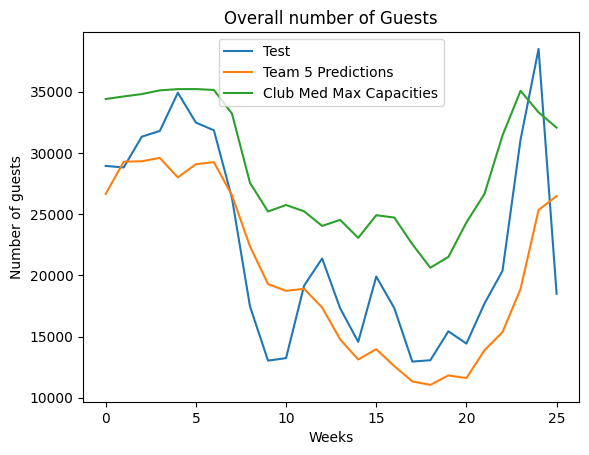

In [103]:
# Plot time series
# plt.plot(X_train.index, y_train, label = "Train")
plt.plot(comparison_df["Actual"].values, label = "Test")
plt.plot(comparison_df["Predicted"].values, label = "Team 5 Predictions")
plt.plot(comparison_df["Manual Prediction"].values, label = "Club Med Max Capacities")

plt.xlabel("Weeks")
plt.ylabel("Number of guests")
plt.title("Overall number of Guests")
plt.legend()

In [104]:
# Check errors
rmse_preds = np.sqrt(mean_squared_error(y_test, y_preds))
mae_preds = mean_absolute_error(y_test, y_preds)
mape_preds = mean_absolute_percentage_error(y_test, y_preds)
smape_preds = sMAPE(y_test, y_preds)

# Calculate metrics for y_manual_preds
rmse_manual_preds = np.sqrt(mean_squared_error(y_test_reset, y_manual_preds_reset))
mae_manual_preds = mean_absolute_error(y_test_reset, y_manual_preds_reset)
mape_manual_preds = mean_absolute_percentage_error(y_test_reset, y_manual_preds_reset)
smape_manual_preds = sMAPE(y_test_reset, y_manual_preds_reset)

# Append results to list
results_feature = [
    {"Method": "Team 5 Predicted", "RMSE": rmse_preds, "MAE": mae_preds, "MAPE": mape_preds, "SMAPE": smape_preds},
    {"Method": "Club Med Prediction", "RMSE": rmse_manual_preds, "MAE": mae_manual_preds, "MAPE": mape_manual_preds, "SMAPE": smape_manual_preds}
]

# Convert list to DataFrame
results_df = pd.DataFrame(results_feature)

results_df

Method         RMSE          MAE      MAPE      SMAPE
0     Team 5 Predicted  5223.680453  4151.165114  0.198157  20.566652
1  Club Med Prediction  7648.938657  6877.807692  0.387953  30.503816

### Predict in 2024

In [105]:
# Predict 13 weeks out in 2024
df_futures = create_future_dates(start_date = "2024-01-06", weeks = 13)

In [106]:
df_futures

week_ref  year  month  week
0  2024-01-06  2024      1     1
1  2024-01-13  2024      1     2
2  2024-01-20  2024      1     3
3  2024-01-27  2024      1     4
4  2024-02-03  2024      2     5
5  2024-02-10  2024      2     6
6  2024-02-17  2024      2     7
7  2024-02-24  2024      2     8
8  2024-03-02  2024      3     9
9  2024-03-09  2024      3    10
10 2024-03-16  2024      3    11
11 2024-03-23  2024      3    12
12 2024-03-30  2024      3    13

In [107]:
df_combined = pd.concat([df_trial, df_futures], ignore_index=True)

    # Fill in time series variables
df_combined = time_series_var(df_combined)

In [108]:
# Predict the target for new row then replace value
weeks = 13
model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 1000) 

for i in range(0,weeks):    
    # Create a copy
    df_co_copy = df_combined.copy().drop(columns = 'week_ref')
    X_train = df_co_copy.drop(columns = 'nbr_gm')
    y_train = df_co_copy['nbr_gm']

    # Fit model [:-weeks+i]
    model.fit(X_train.iloc[:-weeks+i], y_train[:-weeks+i])

        # Fill NaN values with mode

    # Calc mean of rolling_mean to fill NaN
    mean_value = X_train['rolling_mean'].mean()

    # Fill
    X_train.iloc[-weeks+i] = X_train.iloc[-weeks+i].fillna(mean_value)

    # Reshape to use in prediction
    X_last_row = X_train.iloc[-weeks+i].values.reshape(1, -1).astype(float)

    # Y-pred
    y_hat = model.predict(X_last_row)

    # Replace the nbr_gm with y_hat
    new_values = {"nbr_gm": y_hat}
    df_combined.loc[df_combined.index[-weeks+i], new_values.keys()] = new_values.values()

    # Recalc 
    df_combined = time_series_var(df_combined)

In [109]:
df_combined.tail(15)

week_ref  year  month  week        nbr_gm    week_lag_1    week_lag_2  \
312 2023-12-23  2023     12    51  38501.000000  31081.000000  20368.000000   
313 2023-12-30  2023     12    52  18497.000000  38501.000000  31081.000000   
314 2024-01-06  2024      1     1  18963.861328  18497.000000  38501.000000   
315 2024-01-13  2024      1     2  19563.921875  18963.861328  18497.000000   
316 2024-01-20  2024      1     3  18750.292969  19563.921875  18963.861328   
317 2024-01-27  2024      1     4  18421.421875  18750.292969  19563.921875   
318 2024-02-03  2024      2     5  17981.273438  18421.421875  18750.292969   
319 2024-02-10  2024      2     6  18131.679688  17981.273438  18421.421875   
320 2024-02-17  2024      2     7  17653.117188  18131.679688  17981.273438   
321 2024-02-24  2024      2     8  17420.484375  17653.117188  18131.679688   
322 2024-03-02  2024      3     9  15829.539062  17420.484375  17653.117188   
323 2024-03-09  2024      3    10  14034.805664  15829.539062  17420.484375   
324 2024-03-16  2024      3    11  14467.296875  14034.805664  15829.539062   
325 2024-03-23  2024      3    12  16727.628906  14467.296875  14034.805664   
326 2024-03-30  2024      3    13  18405.003906  16727.628906  14467.296875   

     rolling_mean  fourier_transform  
312  20094.888889       1.102899e+05  
313  20224.666667       4.114056e+05  
314  20892.206814       6.496014e+05  
315  21614.087023       4.663523e+05  
316  21982.786241       2.607666e+05  
317  22426.833116       1.478326e+05  
318  22458.641276       1.398472e+05  
319  22210.161241       3.208408e+05  
320  20718.174262       1.930425e+05  
321  18375.894748       2.729177e+04  
322  18079.510200       1.464440e+05  
323  17531.837348       9.226134e+04  
324  16965.545681       2.905941e+05  
325  16740.805230       6.347421e+05  
326  16738.981011       1.011339e+06

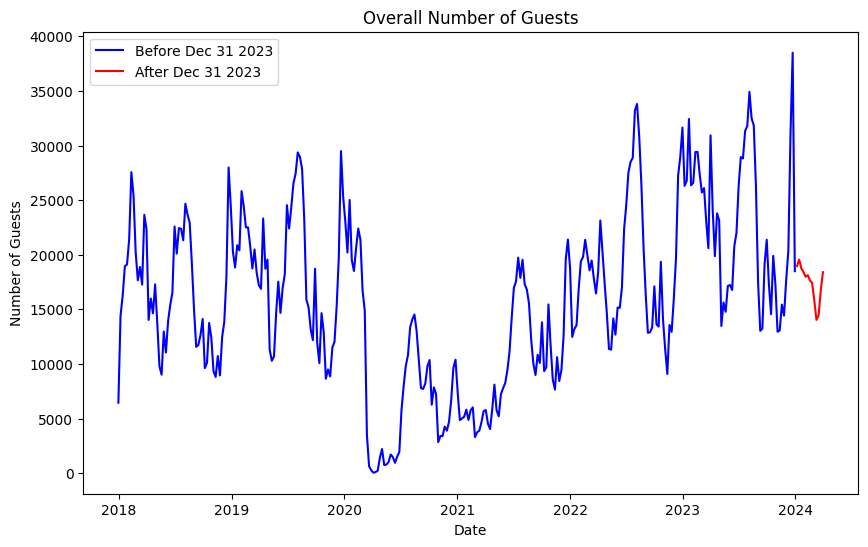

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

comparison_df = df_combined.copy()
# Assuming comparison_df is your DataFrame and 'week_ref' is the column with dates
# Convert 'week_ref' to datetime
comparison_df['week_ref'] = pd.to_datetime(comparison_df['week_ref'])

# Set 'week_ref' as the index of the DataFrame
comparison_df.set_index('week_ref', inplace=True)

# Now, proceed with the plotting
cutoff_date = pd.to_datetime('2023-12-30')
data_before = comparison_df[comparison_df.index <= cutoff_date]
data_after = comparison_df[comparison_df.index > cutoff_date]

plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

plt.plot(data_before.index, data_before["nbr_gm"].values, label="Before Dec 31 2023", color='blue')
plt.plot(data_after.index, data_after["nbr_gm"].values, label="After Dec 31 2023", color='red')

plt.xlabel("Date")
plt.ylabel("Number of Guests")
plt.title("Overall Number of Guests")
plt.legend()
plt.show()


In [111]:
df_futures = create_future_dates(start_date = "2024-01-06", weeks = 52)
df_combined = pd.concat([df_trial, df_futures], ignore_index=True)
df_combined = time_series_var(df_combined)

# Predict the target for new row then replace value
weeks = 52
model = xgb.XGBRegressor(eta= 0.05, max_depth= 4, n_estimators= 1000) 

for i in range(0,weeks):    
    # Create a copy
    df_co_copy = df_combined.copy().drop(columns = 'week_ref')
    X_train = df_co_copy.drop(columns = 'nbr_gm')
    y_train = df_co_copy['nbr_gm']

    # Fit model [:-weeks+i]
    model.fit(X_train.iloc[:-weeks+i], y_train[:-weeks+i])

        # Fill NaN values with mode

    # Calc mean of rolling_mean to fill NaN
    mean_value = X_train['rolling_mean'].mean()

    # Fill
    X_train.iloc[-weeks+i] = X_train.iloc[-weeks+i].fillna(mean_value)

    # Reshape to use in prediction
    X_last_row = X_train.iloc[-weeks+i].values.reshape(1, -1).astype(float)

    # Y-pred
    y_hat = model.predict(X_last_row)

    # Replace the nbr_gm with y_hat
    new_values = {"nbr_gm": y_hat}
    df_combined.loc[df_combined.index[-weeks+i], new_values.keys()] = new_values.values()

    # Recalc 
    df_combined = time_series_var(df_combined)

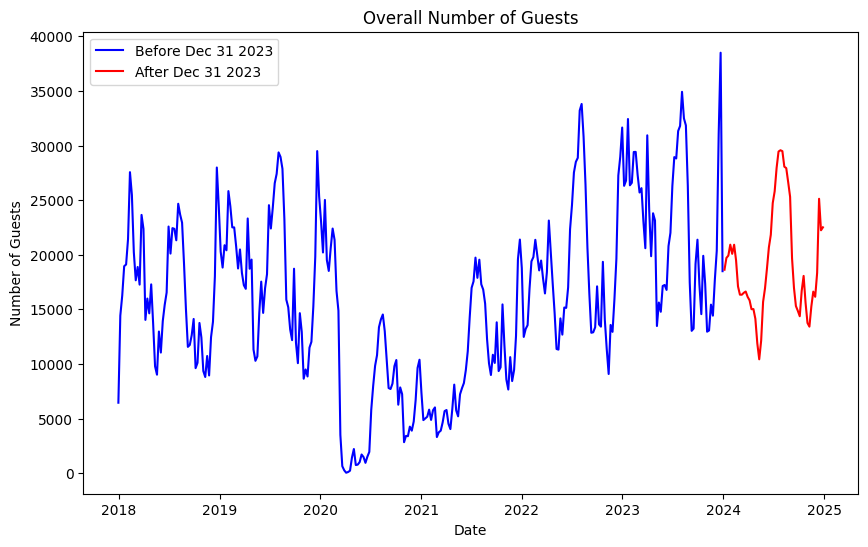

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

comparison_df = df_combined.copy()
# Assuming comparison_df is your DataFrame and 'week_ref' is the column with dates
# Convert 'week_ref' to datetime
comparison_df['week_ref'] = pd.to_datetime(comparison_df['week_ref'])

# Set 'week_ref' as the index of the DataFrame
comparison_df.set_index('week_ref', inplace=True)

# Now, proceed with the plotting
cutoff_date = pd.to_datetime('2023-12-30')
data_before = comparison_df[comparison_df.index <= cutoff_date]
data_after = comparison_df[comparison_df.index > cutoff_date]

plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

plt.plot(data_before.index, data_before["nbr_gm"].values, label="Before Dec 31 2023", color='blue')
plt.plot(data_after.index, data_after["nbr_gm"].values, label="After Dec 31 2023", color='red')

plt.xlabel("Date")
plt.ylabel("Number of Guests")
plt.title("Overall Number of Guests")
plt.legend()
plt.show()

In [113]:
import math

# Create outputs for 3 month, 6 month and end of year of 2024
three_months = math.ceil(comparison_df["nbr_gm"].iloc[-39])
six_months = math.ceil(comparison_df["nbr_gm"].iloc[-26])
end_of_year = math.ceil(comparison_df["nbr_gm"].iloc[-1])

print(f"2024 3 Month mark: {three_months} guests")
print(f"2024 6 Month mark: {six_months} guests")
print(f"2024 End of Year mark: {end_of_year} guests")


2024 3 Month mark: 15831 guests
2024 6 Month mark: 25812 guests
2024 End of Year mark: 22514 guests


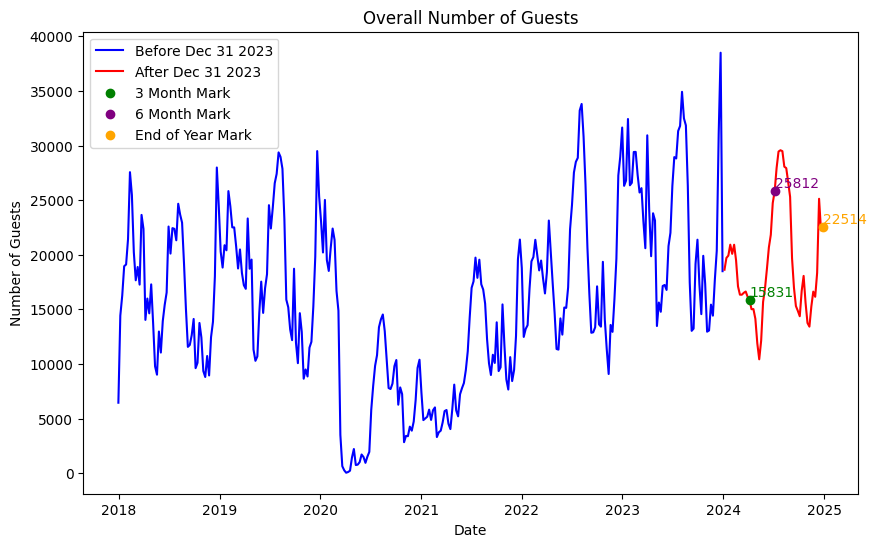

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Disclaimer: ChatGPT helped us in formatting this cell to plot the marks on the future predictions
# Assuming df_combined and comparison_df preparation as before
comparison_df = df_combined.copy()
comparison_df['week_ref'] = pd.to_datetime(comparison_df['week_ref'])
comparison_df.set_index('week_ref', inplace=True)

cutoff_date = pd.to_datetime('2023-12-30')
data_before = comparison_df[comparison_df.index <= cutoff_date]
data_after = comparison_df[comparison_df.index > cutoff_date]

plt.figure(figsize=(10, 6))

plt.plot(data_before.index, data_before["nbr_gm"].values, label="Before Dec 31 2023", color='blue')
plt.plot(data_after.index, data_after["nbr_gm"].values, label="After Dec 31 2023", color='red')

# Calculating rounded-up guest counts
three_months_guests = math.ceil(comparison_df["nbr_gm"].iloc[-39])
six_months_guests = math.ceil(comparison_df["nbr_gm"].iloc[-26])
end_of_year_guests = math.ceil(comparison_df["nbr_gm"].iloc[-1])

# Determining the dates for the .iloc locations
three_months_date = comparison_df.index[-39]
six_months_date = comparison_df.index[-26]
end_of_year_date = comparison_df.index[-1]

# Adding points for the guest counts
plt.scatter(three_months_date, three_months_guests, color='green', label='3 Month Mark', zorder=5)
plt.scatter(six_months_date, six_months_guests, color='purple', label='6 Month Mark', zorder=5)
plt.scatter(end_of_year_date, end_of_year_guests, color='orange', label='End of Year Mark', zorder=5)

# Adding text to show the values on the graph
offset = max(comparison_df["nbr_gm"].values) * 0.01  # Calculate an offset for text to ensure it doesn't overlap the points
plt.text(three_months_date, three_months_guests + offset, str(three_months_guests), color='green')
plt.text(six_months_date, six_months_guests + offset, str(six_months_guests), color='purple')
plt.text(end_of_year_date, end_of_year_guests + offset, str(end_of_year_guests), color='orange')

# Finalizing the plot
plt.xlabel("Date")
plt.ylabel("Number of Guests")
plt.title("Overall Number of Guests")
plt.legend()
plt.show()
